# Analysis

In [1]:
# Adjusting screen 
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [369]:
import networkx as nx
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import IPython
from tqdm import tqdm
import pandas as pd
import matplotlib as mpl
from itertools import count
import geopandas as gpd
import pydot
from networkx.drawing.nx_pydot import to_pydot
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from textwrap import wrap
from matplotlib.ticker import MaxNLocator

plt.rcParams["font.family"] = "Helvetica Neue"

%matplotlib inline

In [8]:
IPC_descriptions = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/All_IPC.txt',sep='	').astype(str)
def translate_ipc(IPC):
    return list(IPC_descriptions.loc[IPC_descriptions['IPC'] == IPC]['Description'])

In [612]:
IPCs_raw = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Updated/Patents/UK_patent_all_IPC_2.csv')
Patents_raw = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Updated/Patents/UK_Patents_cited_wIPC.csv')[['app_nbr','appln_id','reg_code','prio_year','IPC']].drop_duplicates()
Citations_raw = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Updated/Patents/UK_patent_citations.csv')

In [613]:
IPCs_raw['ipc_class_symbol'] = IPCs_raw['ipc_class_symbol'].astype(str).str[:] # Shorten IPC to level n precision
IPCs_raw

Citing_appln_id ipc_class_symbol
0                    64      D21F   1/32
1                    64      D21G   9/00
2                    64      G01N  15/08
3                    76      A47C   7/46
4                    76      B60N   2/66
...                 ...              ...
300842        509041326      G01J   1/16
300843        509041326      G01N  21/31
300844        509041326    G01N  21/3504
300845        509351327      E04B   1/41
300846        509351327      E04G  15/04

[300847 rows x 2 columns]

### Combining data for analysis:  Data to use

In [614]:
patent_ipc_merge = Patents_raw.merge(IPCs_raw, left_on='appln_id', right_on='Citing_appln_id').drop(columns=['IPC','appln_id']).drop_duplicates()
Patents = patent_ipc_merge.rename(columns={'app_nbr':'Application','reg_code':'Region','prio_year':'Patent Year','Citing_appln_id':'ID','ipc_class_symbol':'IPC'}).drop(columns=['ID'])

Citations = Citations_raw.rename(columns={'source':'Source','target':'Target','time':'Citation Year'})

merging_sources = Citations.merge(Patents, left_on='Source', right_on='Application').drop(columns='Application').rename(columns={'Patent Year':'Source Patent Year','Region':'Source Region','IPC':'Source IPC'})
merging_targets = merging_sources.merge(Patents, left_on='Target', right_on='Application').drop(columns='Application').rename(columns={'Patent Year':'Target Patent Year','Region':'Target Region','IPC':'Target IPC'})

Data = merging_targets[['Source','Target','Citation Year','Source IPC','Source Region','Source Patent Year','Target IPC','Target Region','Target Patent Year']].astype(str)

Present_IPCs = sorted(list(set(list(np.array(Data[['Source IPC','Target IPC']]).flatten()))))
Present_Dates_Pat = sorted(list(set(list(np.array(Data[['Source Patent Year','Target Patent Year']]).flatten()))))
Present_Dates_Cit = sorted(list(set(list(np.array(Data[['Citation Year']]).flatten()))))
Present_Regions = sorted(list(set(list(np.array(Data[['Source Region','Target Region']]).flatten()))))

Present_IPCs_Keys = dict(list(zip(Present_IPCs,np.arange(len(Present_IPCs))))) # IPCs associated in alphabetical order with a number

# In degree: Cited
# Out degree: Citing
print('Number of IPCs:',len(Present_IPCs),'|','Number of Dates (Patents):',len(Present_Dates_Pat),'|','Number of Dates (Citations):',len(Present_Dates_Cit),'|','Number of Regions:',len(Present_Regions))

Number of IPCs: 4672 | Number of Dates (Patents): 40 | Number of Dates (Citations): 39 | Number of Regions: 124


In [615]:
Patents_dates = list(zip(list(list(Data['Source'])+list(Data['Target'])),list(list(Data['Source Patent Year'])+list(Data['Target Patent Year']))))
Patents_dates = pd.DataFrame(Patents_dates, columns = [['Patent','Date']])
Patents_dates['IPC'] = list(Data['Source IPC'])+list(Data['Target IPC'])
Patents_dates = Patents_dates.drop_duplicates().astype(str)
Patents_dates.to_clipboard()
Patents_dates = pd.read_clipboard()

# General

### Number of patents

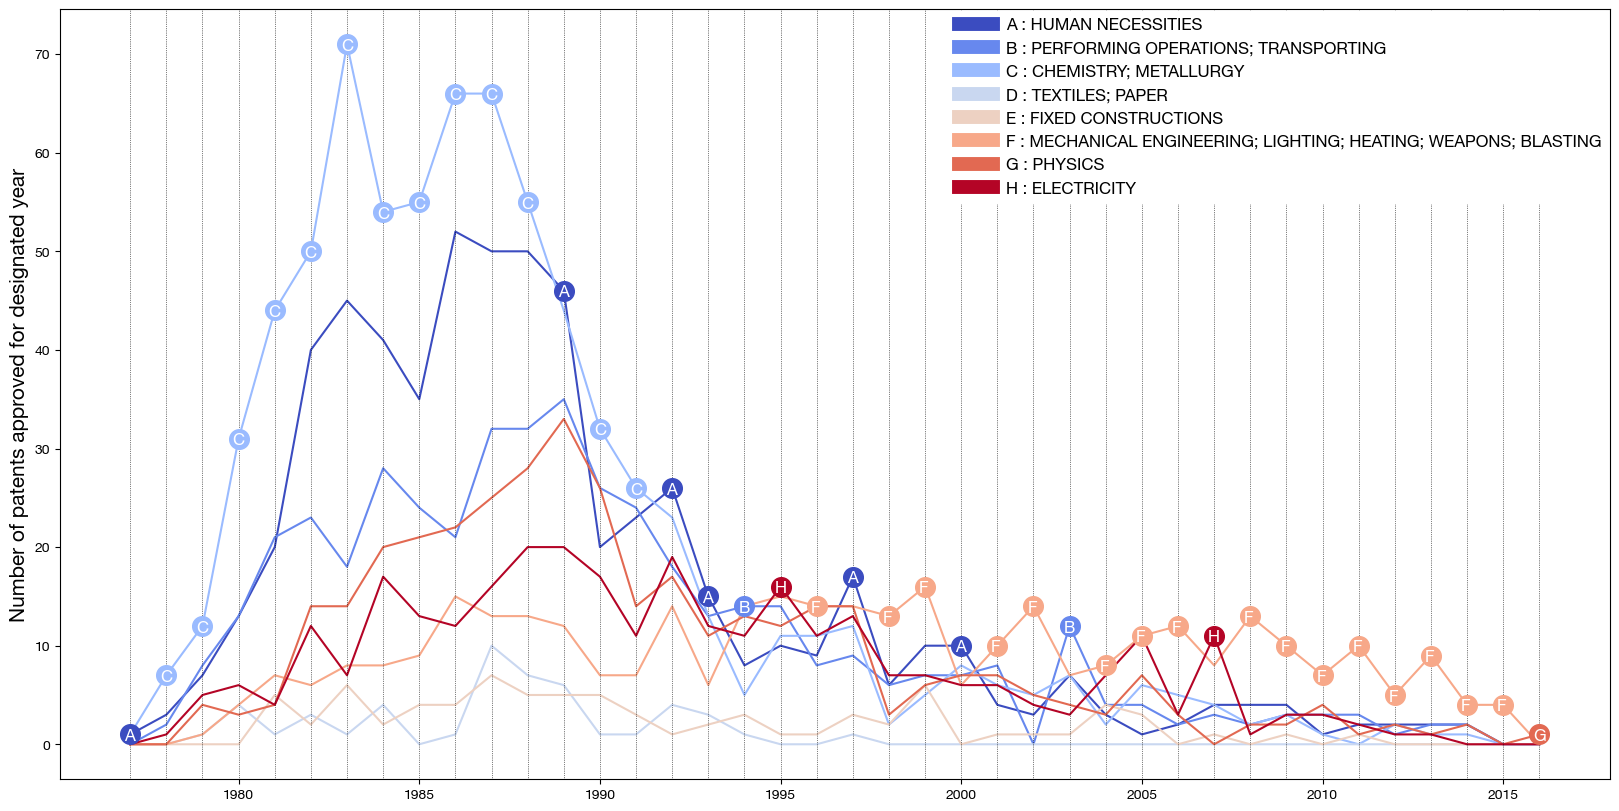

In [3285]:
Storing_array = np.zeros((len(Present_IPCs_Keys),len(Present_Dates_Pat))) # Initialising empty storing array

for i in range(len(Present_Dates_Pat)):
    
    # Creating IPC Citation relationships
    Data_select = Patents_dates.loc[Patents_dates['Date'] == int(Present_Dates_Pat[i])] # Selecting all patents created in specific year
    Counts_prelim = dict(Data_select['IPC'].value_counts()) # Converting multiple citation counts into weights
    extract_information = list(zip(list(Counts_prelim.keys()),list(Counts_prelim.values())))

    # Storing all values into the storing array
    for j in range(len(extract_information)):
        Storing_array[Present_IPCs_Keys[extract_information[j][0]]][i] = extract_information[j][1]
        
plt.figure(figsize=(20, 10))
Dates_plotting = np.arange(min(np.array(Present_Dates_Pat).astype(int)), max(np.array(Present_Dates_Pat).astype(int)) + 1) # Dates for plotting
Colors = pl.cm.coolwarm(np.linspace(0, 1, len(Present_IPCs))) # Colors for plotting

Most_Cited = []
for i in range(len(Present_Dates_Pat)):
    Most_Cited.append(list(Present_IPCs_Keys.keys())[np.argmax(Storing_array.T[i])])

for k in range(len(Present_IPCs_Keys)):
    plt.plot(Dates_plotting, Storing_array[k], color=Colors[k], label=f'{list(Present_IPCs_Keys.keys())[k]} : {translate_ipc(list(Present_IPCs_Keys.keys())[k])[0]}')

for k in range(len(Dates_plotting)):
    plt.axvline(x=Dates_plotting[k], color='black', linestyle=':', linewidth=0.5)
    highest_point = max(Storing_array[:, k])  # Get the highest point for this instance
    plt.text(Dates_plotting[k] - 0.17, highest_point + -0.6, Most_Cited[k], fontsize=12, zorder=20, color='White')  # Adjust the y coordinate to move the text above the highest point and set zorder to 10
    plt.scatter(Dates_plotting[k], highest_point, color=Colors[Present_IPCs_Keys[Most_Cited[k]]], s=200, zorder=10)  # Add a point at the highest point and set zorder to 10

leg = plt.legend(loc='upper right', borderaxespad=0.1, fancybox=True, facecolor='white', frameon=True, framealpha=1, edgecolor='white', fontsize=12) 
for line in leg.get_lines():
    line.set_linewidth(10) 

#plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of patents approved for designated year', fontsize=15)
plt.show()

### Number of patents (Normalised stack)

/var/folders/7f/r079rwbx56v6qwwwwxq2cpzw0000gn/T/ipykernel_24771/2454849867.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


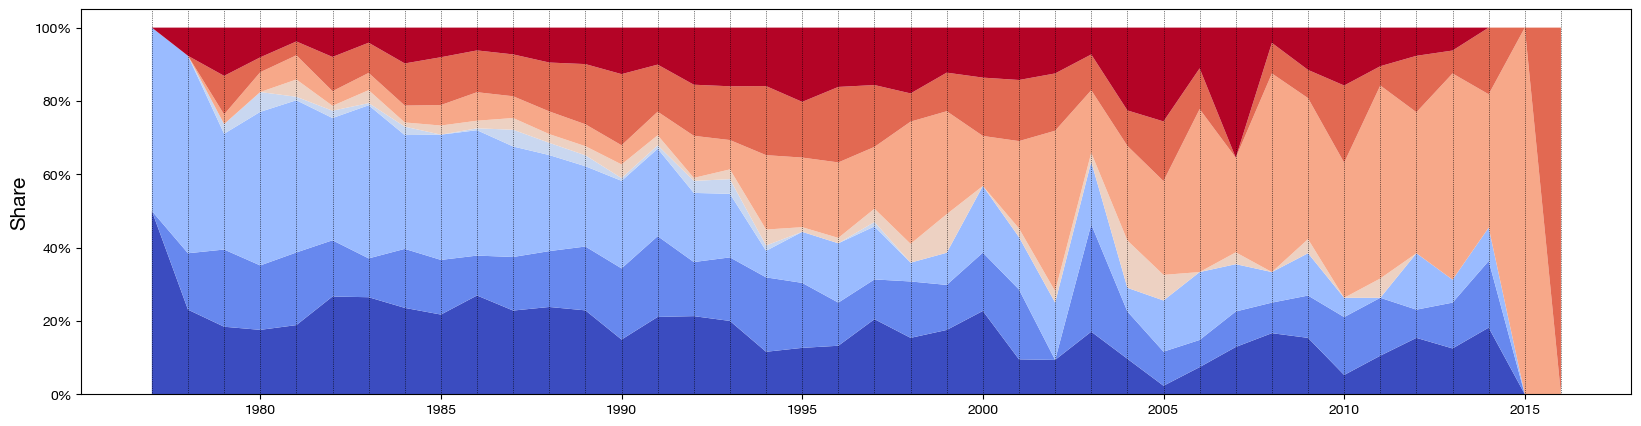

In [3296]:
Storing_array = np.zeros((len(Present_IPCs_Keys),len(Present_Dates_Pat))) # Initialising empty storing array

for i in range(len(Present_Dates_Pat)):
    
    # Creating IPC Citation relationships
    Data_select = Patents_dates.loc[Patents_dates['Date'] == int(Present_Dates_Pat[i])] # Selecting all patents created in specific year
    Counts_prelim = dict(Data_select['IPC'].value_counts()) # Converting multiple citation counts into weights
    extract_information = list(zip(list(Counts_prelim.keys()),list(Counts_prelim.values())))

    # Storing all values into the storing array
    for j in range(len(extract_information)):
        Storing_array[Present_IPCs_Keys[extract_information[j][0]]][i] = extract_information[j][1]

for i in range(len(Storing_array.T)):
    if np.sum(Storing_array.T[i]) != 0:
        Storing_array.T[i] = Storing_array.T[i]/(np.sum(Storing_array.T[i]))
        
plt.figure(figsize=(20, 5))
Dates_plotting = np.arange(min(np.array(Present_Dates_Pat).astype(int)), max(np.array(Present_Dates_Pat).astype(int)) + 1) # Dates for plotting
Colors = pl.cm.coolwarm(np.linspace(0, 1, len(Present_IPCs))) # Colors for plotting

Most_Cited = []
for i in range(len(Present_Dates_Pat)):
    Most_Cited.append(list(Present_IPCs_Keys.keys())[np.argmax(Storing_array.T[i])])

plt.stackplot(Dates_plotting,Storing_array,labels=Present_IPCs_Keys.keys(),colors = Colors)

for k in range(len(Dates_plotting)):
    plt.axvline(x=Dates_plotting[k], color='black', linestyle=':', linewidth=0.5)
    #highest_point = 2  # Get the highest point for this instance
    #plt.text(Dates_plotting[k], 1+0.01, Most_Cited[k], fontsize=12, zorder=20, color='Black')  # Adjust the y coordinate to move the text above the highest point and set zorder to 10
    #plt.scatter(Dates_plotting[k], highest_point, color=Colors[Present_IPCs_Keys[Most_Cited[k]]], s=200, zorder=10)  # Add a point at the highest point and set zorder to 10

#plt.legend(loc='upper right', borderaxespad=0.1, fancybox=True, facecolor='white', frameon=True, framealpha=1, edgecolor='white') 
#plt.xlabel('Year', fontsize=15)
plt.ylabel('Share', fontsize=15)
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.show()

Storing_array_PAT = Storing_array

# Number of patents correlation matrix

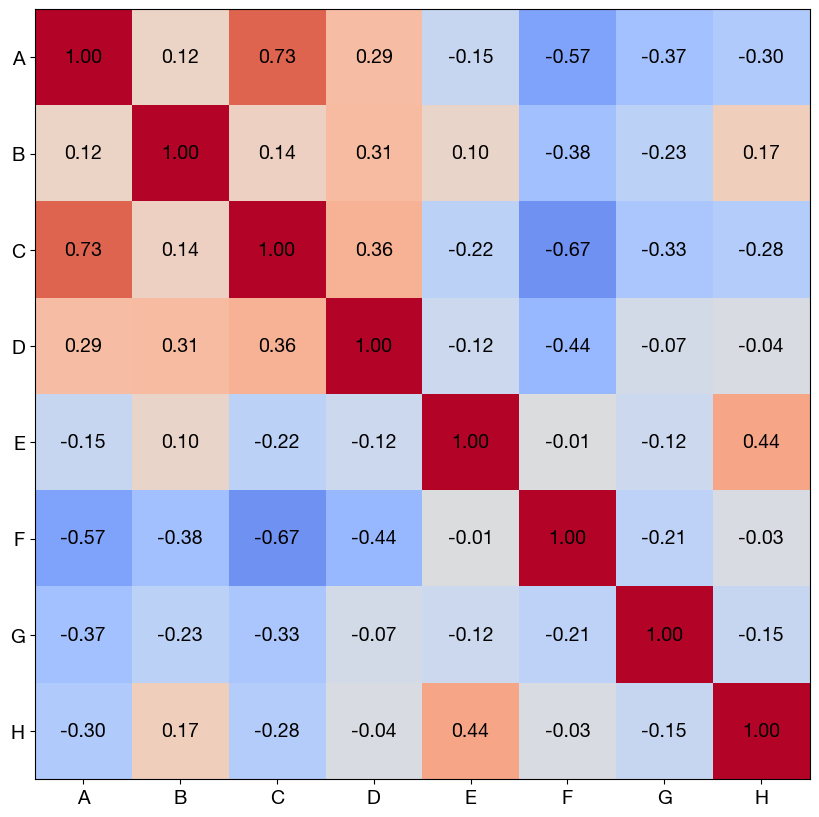

In [3284]:
matrix_pd = pd.DataFrame(Storing_array.T,columns=Present_IPCs)
matrix_corr = matrix_pd.corr()
matrix_plot = np.array(matrix_corr)
labels = list(matrix_corr)

plt.figure(figsize=(10, 10),dpi=100)
plt.imshow(matrix_plot, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, f'{matrix_plot[i, j]:.2f}', ha='center', va='center', fontsize=14, color='black')

plt.xticks(np.arange(len(labels)), labels, fontsize=14)
plt.yticks(np.arange(len(labels)), labels, fontsize=14)

#plt.title('Correlation Matrix')
plt.show()

### Number of citations

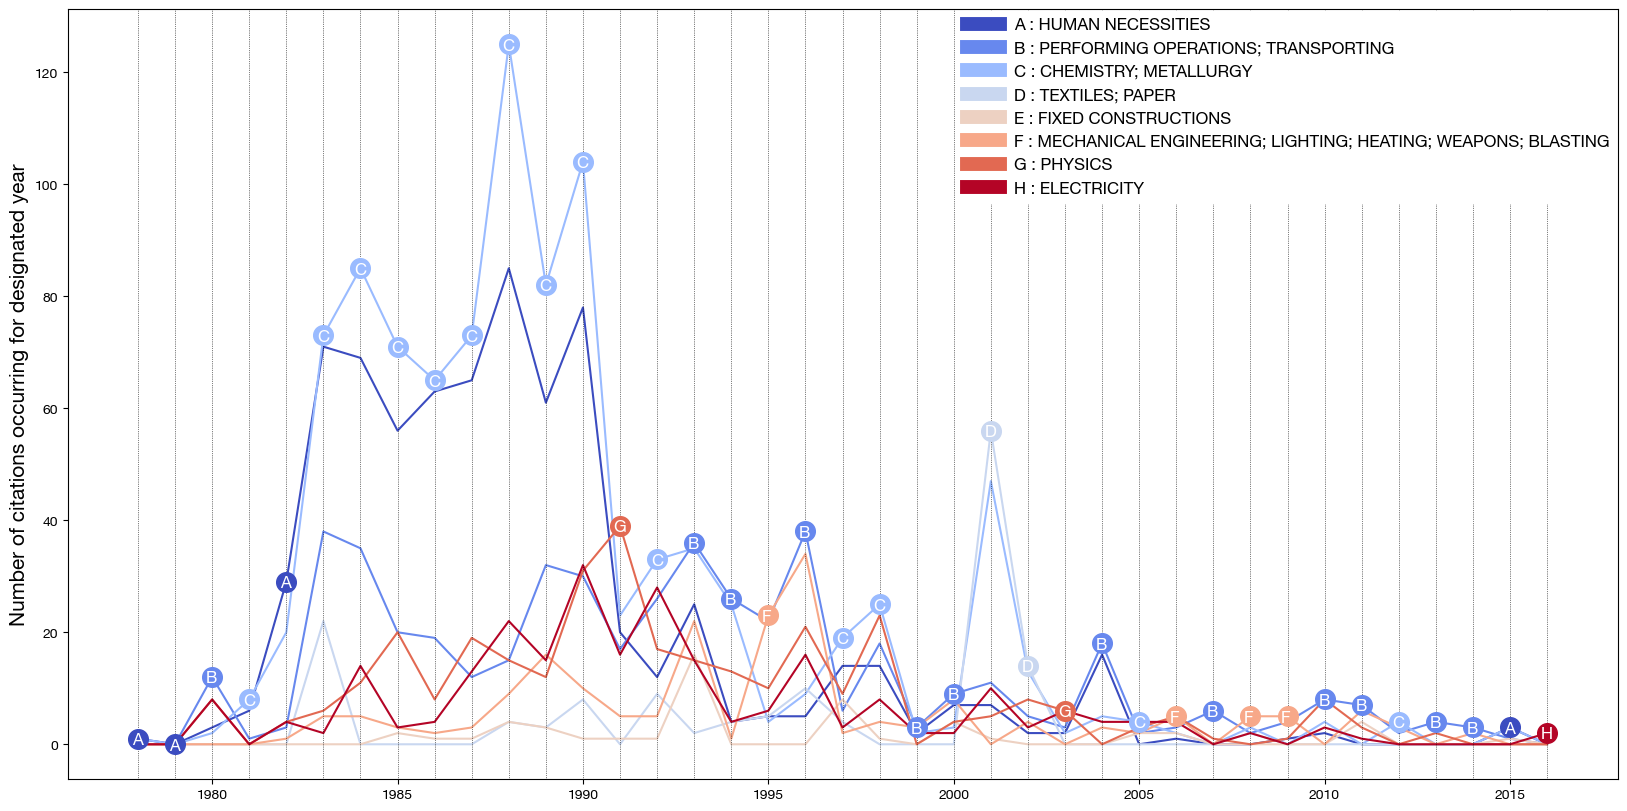

In [3286]:
Storing_array = np.zeros((len(Present_IPCs_Keys),len(Present_Dates_Cit))) # Initialising empty storing array

for i in range(len(Present_Dates_Cit)):
    
    # Creating IPC Citation relationships
    Data_select = Data.loc[Data['Citation Year'] == Present_Dates_Cit[i]] # Selecting all patents created in specific year
    Counts_prelim = dict(Data_select[['Source IPC','Target IPC']].value_counts()) # Converting multiple citation counts into weights
    Counts = [(key[0], key[1], value) for key, value in Counts_prelim.items()] # Formatted correctly
    
    # Creating graph
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(Counts)
    graph.remove_edges_from(nx.selfloop_edges(graph)) # NOT ACCOUNTING FOR SELF CITATIONS
    extract_information = list(graph.in_degree(weight='weight')) # Accounting for the counts
    
    # Storing all values into the storing array
    for j in range(len(extract_information)):
        Storing_array[Present_IPCs_Keys[extract_information[j][0]]][i] = extract_information[j][1]
        
plt.figure(figsize=(20, 10))
Dates_plotting = np.arange(min(np.array(Present_Dates_Cit).astype(int)), max(np.array(Present_Dates_Cit).astype(int)) + 1) # Dates for plotting
Colors = pl.cm.coolwarm(np.linspace(0, 1, len(Present_IPCs))) # Colors for plotting

Most_Cited = []
for i in range(len(Present_Dates_Cit)):
    Most_Cited.append(list(Present_IPCs_Keys.keys())[np.argmax(Storing_array.T[i])])

for k in range(len(Present_IPCs_Keys)):
    plt.plot(Dates_plotting, Storing_array[k], color=Colors[k], label=f'{list(Present_IPCs_Keys.keys())[k]} : {translate_ipc(list(Present_IPCs_Keys.keys())[k])[0]}')

for k in range(len(Dates_plotting)):
    plt.axvline(x=Dates_plotting[k], color='black', linestyle=':', linewidth=0.5)
    highest_point = max(Storing_array[:, k])  # Get the highest point for this instance
    plt.text(Dates_plotting[k] - 0.17, highest_point + -1, Most_Cited[k], fontsize=12, zorder=20, color='White')  # Adjust the y coordinate to move the text above the highest point and set zorder to 10
    plt.scatter(Dates_plotting[k], highest_point, color=Colors[Present_IPCs_Keys[Most_Cited[k]]], s=200, zorder=10)  # Add a point at the highest point and set zorder to 10

leg = plt.legend(loc='upper right', borderaxespad=0.1, fancybox=True, facecolor='white', frameon=True, framealpha=1, edgecolor='white', fontsize=12) 
for line in leg.get_lines():
    line.set_linewidth(10) 

plt.ylabel('Number of citations occurring for designated year', fontsize=15)
plt.show()

### Number of citations (Normalised stack)

/var/folders/7f/r079rwbx56v6qwwwwxq2cpzw0000gn/T/ipykernel_24771/3047995469.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


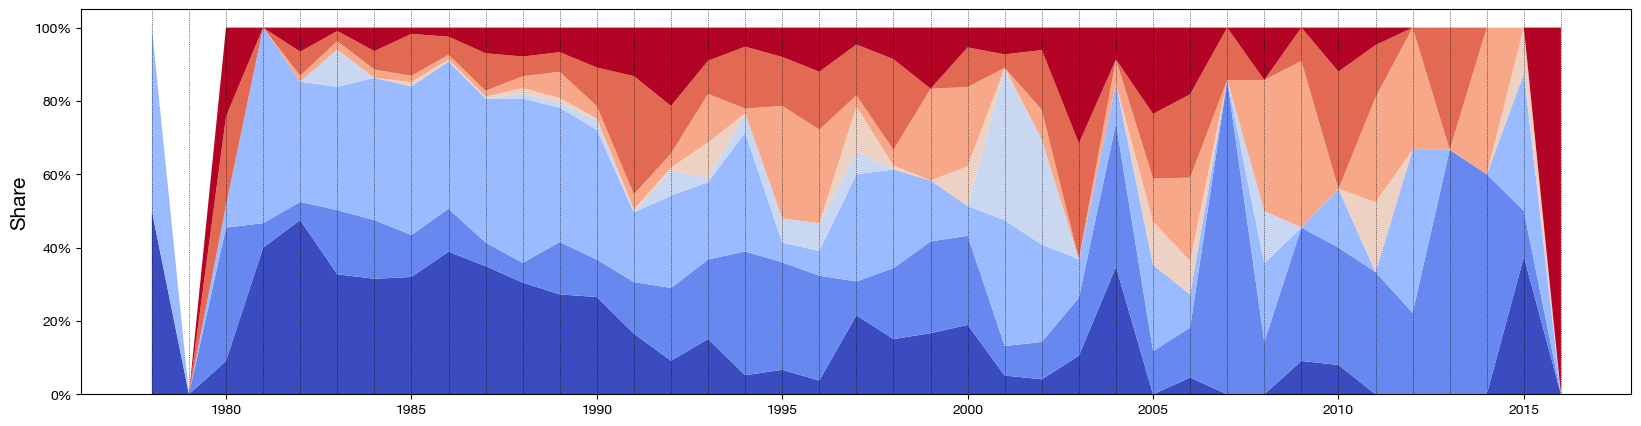

In [3297]:
Storing_array = np.zeros((len(Present_IPCs_Keys),len(Present_Dates_Cit))) # Initialising empty storing array

for i in range(len(Present_Dates_Cit)):
    
    # Creating IPC Citation relationships
    Data_select = Data.loc[Data['Citation Year'] == Present_Dates_Cit[i]] # Selecting all patents created in specific year
    Counts_prelim = dict(Data_select[['Source IPC','Target IPC']].value_counts()) # Converting multiple citation counts into weights
    Counts = [(key[0], key[1], value) for key, value in Counts_prelim.items()] # Formatted correctly
    
    # Creating graph
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(Counts)
    graph.remove_edges_from(nx.selfloop_edges(graph)) # NOT ACCOUNTING FOR SELF CITATIONS
    extract_information = list(graph.in_degree(weight='weight')) # Accounting for the counts
    
    # Storing all values into the storing array
    for j in range(len(extract_information)):
        Storing_array[Present_IPCs_Keys[extract_information[j][0]]][i] = extract_information[j][1]

for i in range(len(Storing_array.T)):
    if np.sum(Storing_array.T[i]) != 0:
        Storing_array.T[i] = Storing_array.T[i]/(np.sum(Storing_array.T[i]))
        
plt.figure(figsize=(20, 5))
Dates_plotting = np.arange(min(np.array(Present_Dates_Cit).astype(int)), max(np.array(Present_Dates_Cit).astype(int)) + 1) # Dates for plotting
Colors = pl.cm.coolwarm(np.linspace(0, 1, len(Present_IPCs))) # Colors for plotting

Most_Cited = []
for i in range(len(Present_Dates_Cit)):
    Most_Cited.append(list(Present_IPCs_Keys.keys())[np.argmax(Storing_array.T[i])])

plt.stackplot(Dates_plotting,Storing_array,labels=Present_IPCs_Keys.keys(),colors = Colors)

for k in range(len(Dates_plotting)):
    plt.axvline(x=Dates_plotting[k], color='black', linestyle=':', linewidth=0.5)
    #highest_point = 2  # Get the highest point for this instance
    #plt.text(Dates_plotting[k], 1+0.01, Most_Cited[k], fontsize=12, zorder=20, color='Black')  # Adjust the y coordinate to move the text above the highest point and set zorder to 10
    #plt.scatter(Dates_plotting[k], highest_point, color=Colors[Present_IPCs_Keys[Most_Cited[k]]], s=200, zorder=10)  # Add a point at the highest point and set zorder to 10

#plt.legend(loc='upper right', borderaxespad=0.1, fancybox=True, facecolor='white', frameon=True, framealpha=1, edgecolor='white') 
#plt.xlabel('Year', fontsize=15)
plt.ylabel('Share', fontsize=15)
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.show()

Storing_array_CIT = Storing_array

# Number of citations correlation matrix

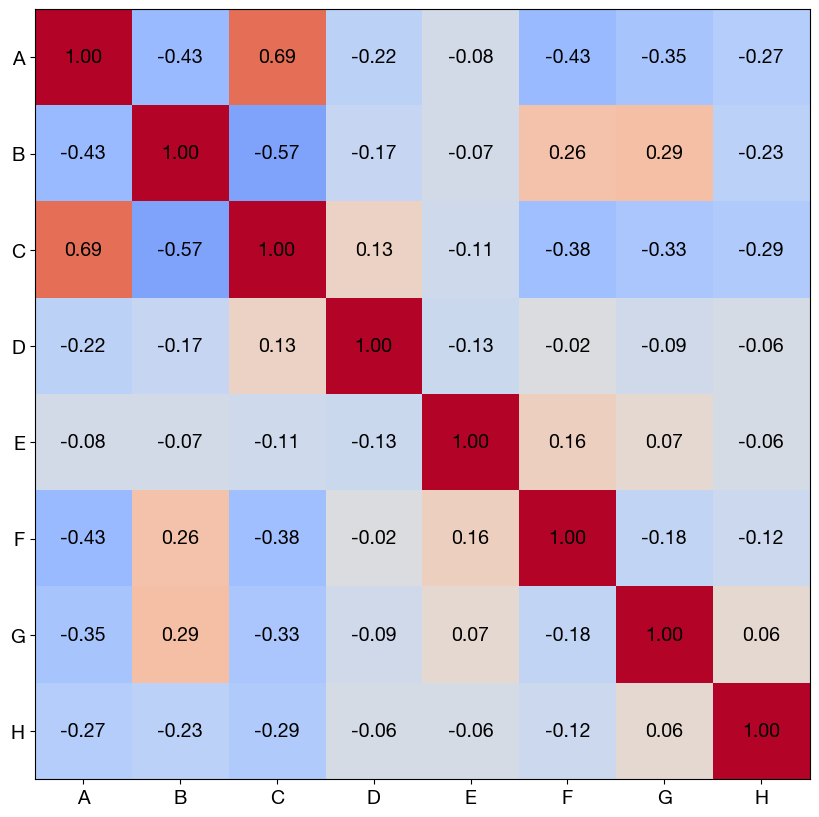

In [3281]:
matrix_pd = pd.DataFrame(Storing_array.T,columns=Present_IPCs)
matrix_corr = matrix_pd.corr()
matrix_plot = np.array(matrix_corr)
labels = list(matrix_corr)

plt.figure(figsize=(10, 10),dpi=100)
plt.imshow(matrix_plot, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, f'{matrix_plot[i, j]:.2f}', ha='center', va='center', fontsize=14, color='black')

plt.xticks(np.arange(len(labels)), labels, fontsize=14)
plt.yticks(np.arange(len(labels)), labels, fontsize=14)

#plt.title('Correlation Matrix')
plt.show()

# Cross-correlation

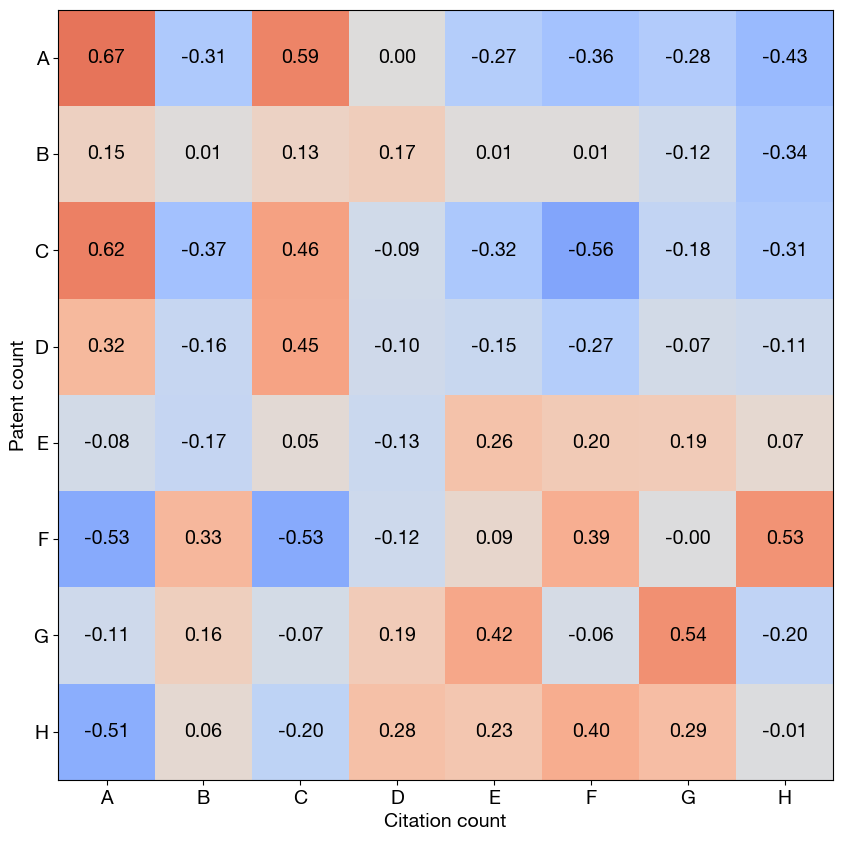

In [3317]:
matrix_pd_PAT = pd.DataFrame(Storing_array_PAT.T,columns=Present_IPCs)
matrix_pd_CIT = pd.DataFrame(Storing_array_CIT.T,columns=Present_IPCs)
labels = Present_IPCs

matrix_PC = np.zeros((len(Present_IPCs),len(Present_IPCs)))
for j in range(len(Present_IPCs)):
    for i in range(len(Present_IPCs)):
        matrix_PC[j][i] = matrix_pd_PAT[Present_IPCs[j]].corr(matrix_pd_CIT[Present_IPCs[i]])

plt.figure(figsize=(10, 10),dpi=100)
plt.imshow(matrix_PC, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, f'{matrix_PC[i, j]:.2f}', ha='center', va='center', fontsize=14, color='black')

plt.xlabel('Citation count', fontsize=14)
plt.ylabel('Patent count', fontsize=14)
plt.xticks(np.arange(len(labels)), labels, fontsize=14)
plt.yticks(np.arange(len(labels)), labels, fontsize=14)

#plt.title('Correlation Matrix')
plt.show()

In [3334]:
graph = ig.Graph(directed=True)
graph.add_vertices(Present_IPCs)
graph.Weighted_Adjacency(matrix_PC+1)
graph.es['weight']

SyntaxError: invalid syntax (38475328.py, line 4)

KeyError: 'Attribute does not exist'

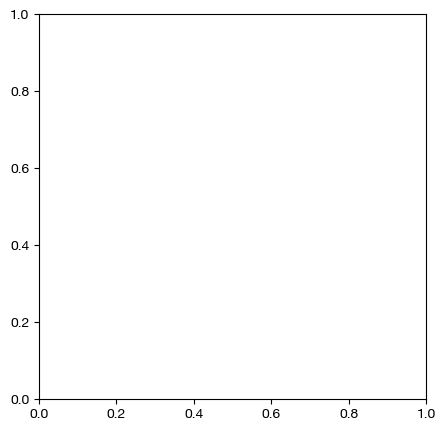

In [3325]:
colormap = plt.cm.get_cmap('coolwarm')  # Choose any colormap you like

fig, ax = plt.subplots(figsize=(5, 5))

ig.plot(
    graph,
    layout=graph.layout(layout='reingold_tilford_circular'),
    target=ax,
    vertex_size=[s * 0.015 + 0.005 for s in in_degrees],
    mark_groups=True,
    vertex_frame_width=1.0,
    vertex_frame_color='White',
    vertex_label=graph.vs["name"],
    vlabel_size=10.0,
    vertex_color=[colormap(d/max_in_degrees) for d in in_degrees],
    edge_width=[w*0.01 + 0.05 for w in graph.es['weight']],
    vertex_label_color='White',
    edge_color=[colormap(w/max(graph.es['weight'])) for w in graph.es['weight']],
    edge_arrow_size=[w*0.00001 + 0.001 for w in graph.es['weight']]
)

fig.set_size_inches(20, 20)
plt.show()

# Characteristics

In [2942]:
Data_CHA = Data[['Source','Target','Source Patent Year','Target Patent Year']].drop_duplicates().astype(str)

In [3014]:
av_clust = []
av_clust_ind = []
edges_source = []
edges_target = []

for i in range(len(Present_Dates_Pat)):
    Data_CHA_u = Data_CHA.loc[Data_CHA['Source Patent Year'] == Present_Dates_Pat[i]]
    
    edges_source_ind = list(Data_CHA_u['Source'])
    edges_target_ind = list(Data_CHA_u['Target'])
    edges_source_ind = [item for sublist in edges_source_ind for item in (sublist if isinstance(sublist, list) else [sublist])]
    edges_target_ind = [item for sublist in edges_target_ind for item in (sublist if isinstance(sublist, list) else [sublist])]
    edges_ind = list(zip(list(edges_source_ind),list(edges_target_ind)))

    # Creating graph
    graph = nx.DiGraph()
    graph.add_edges_from(edges_ind)
    av_clust_ind.append(nx.average_clustering(graph))
    
    edges_source.append(edges_source_ind)
    edges_target.append(edges_target_ind)
    edges_source = [item for sublist in edges_source for item in (sublist if isinstance(sublist, list) else [sublist])]
    edges_target = [item for sublist in edges_target for item in (sublist if isinstance(sublist, list) else [sublist])]
    edges = list(zip(list(edges_source),list(edges_target)))
    
    # Creating graph
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    av_clust.append(nx.average_clustering(graph))
    

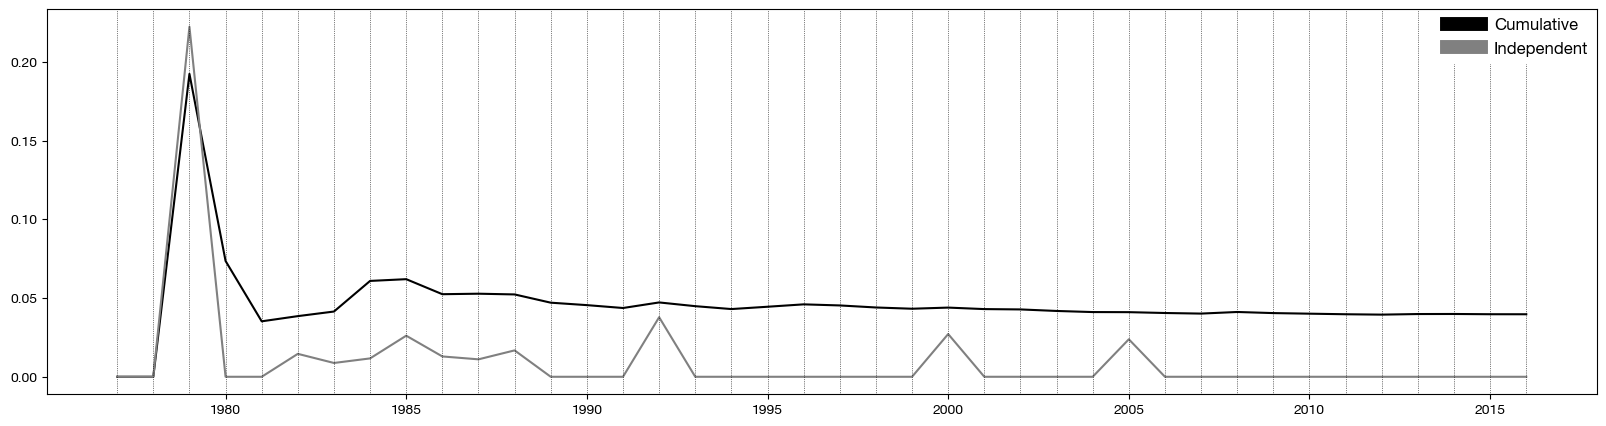

In [3020]:
plt.figure(figsize=(20,5))
Dates_plotting = np.arange(min(np.array(Present_Dates_Pat).astype(int)), max(np.array(Present_Dates_Pat).astype(int)) + 1) # Dates for plotting
plt.plot(Dates_plotting, av_clust, color='black', label='Cumulative')
plt.plot(Dates_plotting, av_clust_ind, color='grey', label='Independent')

for k in range(len(Dates_plotting)):
    plt.axvline(x=Dates_plotting[k], color='black', linestyle=':', linewidth=0.5)
    
leg = plt.legend(loc='upper right', borderaxespad=0.1, fancybox=True, facecolor='white', frameon=True, framealpha=1, edgecolor='white', fontsize=12) 
for line in leg.get_lines():
    line.set_linewidth(10) 
plt.show()

# Specific

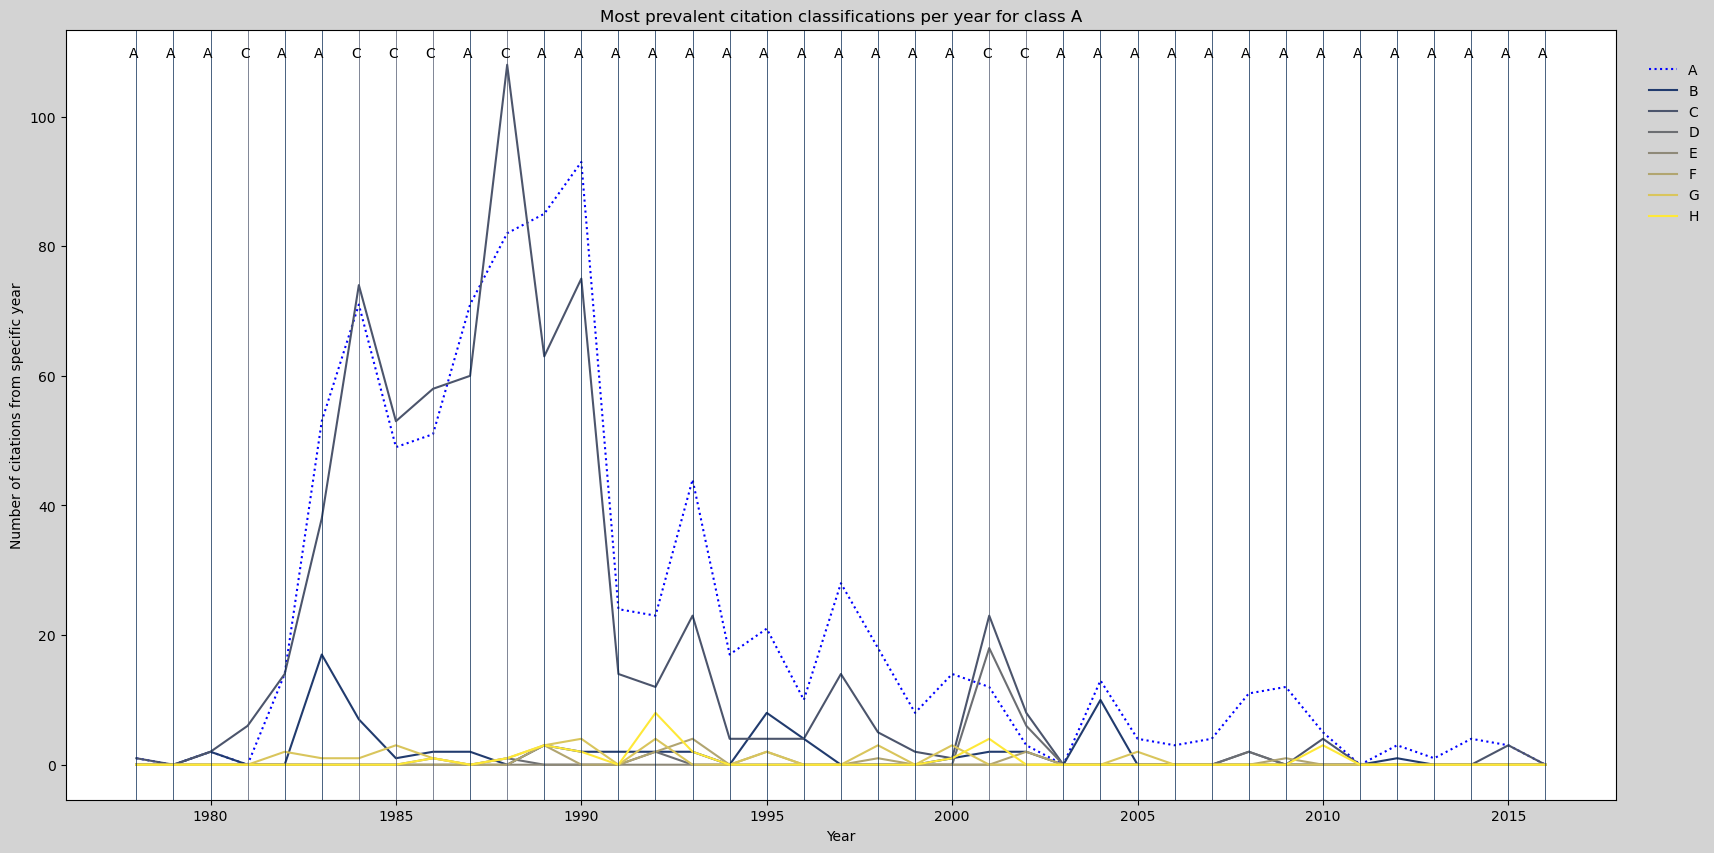

In [694]:
Storing_array = np.zeros((len(Present_IPCs_Keys),len(Present_Dates_Cit))) # Initialising empty storing array
IPC_Selected = Present_IPCs[0] # Select the IPC

for i in range(len(Present_Dates_Cit)):
    
    # Creating IPC Citation relationships
    Data_select = Data.loc[Data['Citation Year'] == Present_Dates_Cit[i]] # Selecting all patents created in specific year
    Data_select = Data_select.loc[Data_select['Source IPC'] == IPC_Selected] # Now choose IPC class of interest
    Counts_prelim = dict(Data_select[['Source IPC','Target IPC']].value_counts()) # Converting multiple citation counts into weights
    Counts = [(key[0], key[1], value) for key, value in Counts_prelim.items()] # Formatted correctly
    
    # Creating graph
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(Counts)
    extract_information = list(graph.in_degree(weight='weight')) # Accounting for the counts
    
    # Storing all values into the storing array
    for j in range(len(extract_information)):
        Storing_array[Present_IPCs_Keys[extract_information[j][0]]][i] = extract_information[j][1]
        
plt.figure(figsize=(20,10),facecolor='lightgrey')
Dates_plotting = np.arange(min(np.array(Present_Dates_Cit).astype(int)),max(np.array(Present_Dates_Cit).astype(int))+1) # Dates for plotting
Colors = pl.cm.cividis(np.linspace(0,1,len(Present_IPCs))) # Colors for plotting

Most_Cited = []
for i in range(len(Present_Dates_Cit)):
    Most_Cited.append(list(Present_IPCs_Keys.keys())[np.argmax(Storing_array.T[i])])
    
for k in range(len(Present_IPCs_Keys)):
    if list(Present_IPCs_Keys.keys())[k] != IPC_Selected:
        plt.plot(Dates_plotting, Storing_array[k], color=Colors[k], label=list(Present_IPCs_Keys.keys())[k])
    else:
        plt.plot(Dates_plotting, Storing_array[k], color='Blue', linestyle=':', label=list(Present_IPCs_Keys.keys())[k])

for k in range(len(Dates_plotting)):
    plt.axvline(x=Dates_plotting[k], color=Colors[Present_IPCs_Keys[Most_Cited[k]]], linewidth=0.5)
    plt.text(Dates_plotting[k]-0.2, max(Storing_array.flatten())+max(Storing_array.flatten())/100, Most_Cited[k], fontsize=10)
    
plt.legend(frameon=False,loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=2)
plt.title(f'Most prevalent citation classifications per year for class {IPC_Selected}')
plt.xlabel('Year')
plt.ylabel('Number of citations from specific year')
plt.show()

# Mapping IPC presence

In [1145]:
shapefile = gpd.read_file("/Users/joebacchus/Desktop/Bartlett CASA/NUTS Shapefiles/NUTS_RG_20M_2021_3035.shp")
shapefile_UK = shapefile.loc[shapefile['CNTR_CODE'] == "UK"] # Can modify UK
shapefile_UK = shapefile_UK.loc[shapefile_UK['LEVL_CODE'] == 3][['NUTS_ID','geometry']].rename(columns={'NUTS_ID':'Region','geometry':'geometry'}) # Restricting to selected NUTS

In [1146]:
Regions_shapefile = list(shapefile_UK['Region'])

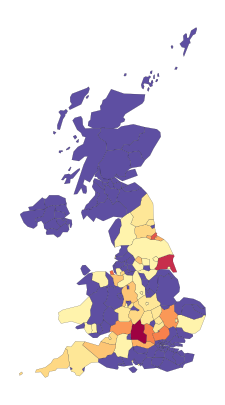

In [1155]:
IPC_Selected = 'B01' # Select the IPC
Storing_array = []

for i in range(len(Regions_shapefile)):
    IPC_count_region = dict(Patents.loc[Patents['Region'] == Regions_shapefile[i]]['IPC'].value_counts())
    IPC_count_region = pd.DataFrame(list(zip(list(IPC_count_region.keys()),list(IPC_count_region.values()))),columns=[['IPC','Count']])
    store_value = np.array(IPC_count_region.loc[(IPC_count_region['IPC'] == IPC_Selected).values]['Count']).flatten()
    Storing_array.append(store_value) # Add count of particular IPC to array
    
Storing_array = [-1000 if x.size == 0 else x.item() for x in Storing_array]
shapefile_UK['Values'] = Storing_array # Assigning to the values

# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
cmap = 'Spectral_r'
norm = plt.Normalize(-shapefile_UK['Values'].max(), shapefile_UK['Values'].max())
shapefile_UK.plot(ax=ax, column='Values', cmap=cmap, linewidth=0.1, edgecolor='black', norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.02)
cbar.set_label('Values')

ax.axis("off")
plt.show()

# Graphing

### Citations unnormalised total

In [3024]:
graph = ig.Graph(directed=True)
graph.add_vertices(Present_IPCs)
graph.add_edges(list(dict(Data[['Source IPC','Target IPC']].value_counts()).keys()))
graph.simplify() # Remove self loops
to_delete_ids = [v.index for v in graph.vs if v.degree() == 0] # Delete isolated nodes
graph.delete_vertices(to_delete_ids)

# Adding weights
Counts_prelim = dict(Data[['Source IPC','Target IPC']].value_counts())
graph.es['weight'] = list(Counts_prelim.values())

communities = graph.community_edge_betweenness(weights=graph.es['weight'])
communities = communities.as_clustering()
bridges = graph.bridges()

in_degrees = graph.degree(mode='in')
max_in_degrees = max(in_degrees)

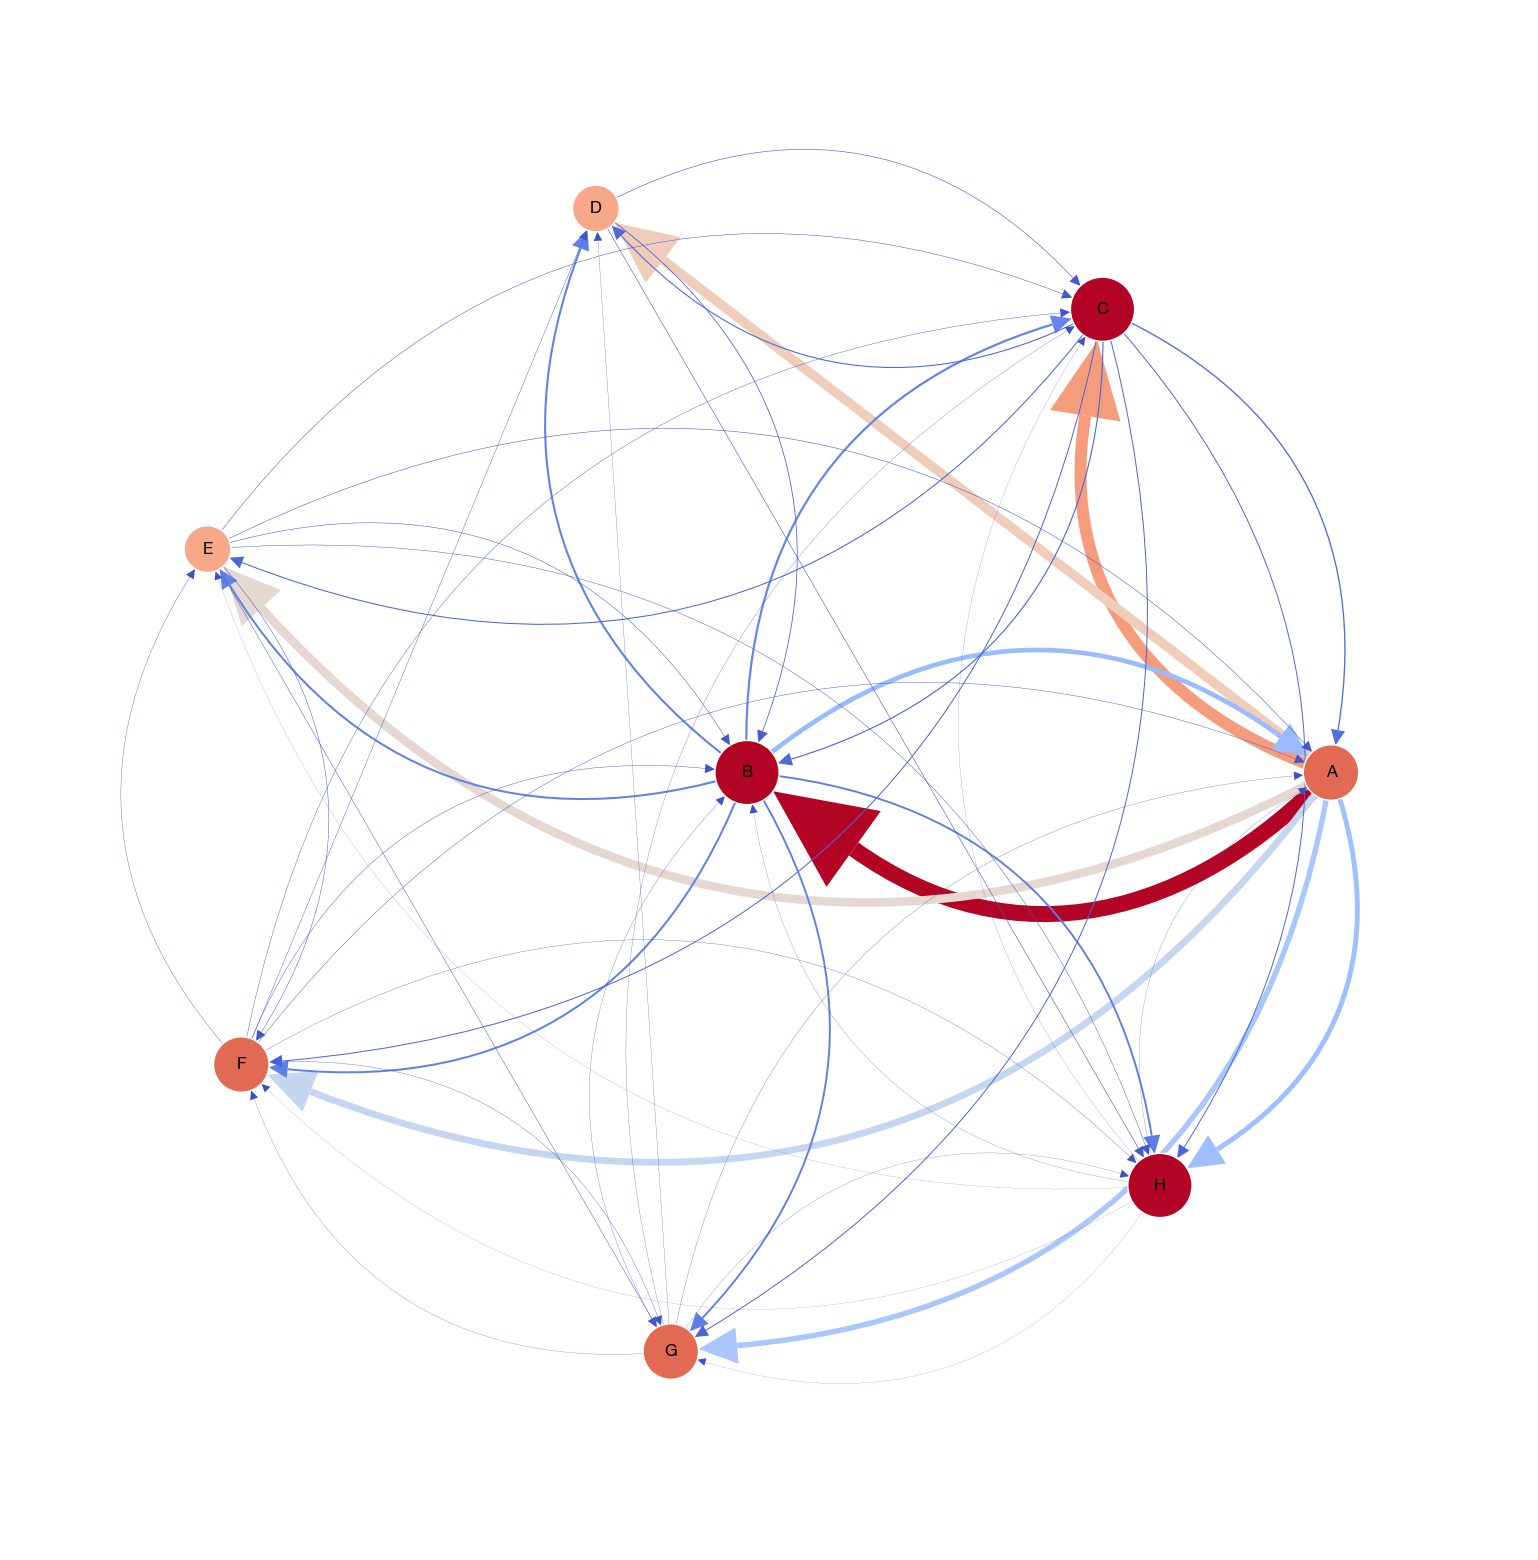

In [3025]:
# Define a colormap for node colors
colormap = plt.cm.get_cmap('coolwarm')  # Choose any colormap you like

fig, ax = plt.subplots(figsize=(5, 5))

ig.plot(
    graph,
    layout=graph.layout(layout='reingold_tilford_circular'),
    target=ax,
    vertex_size=[s * 0.015 + 0.005 for s in in_degrees],
    mark_groups=True,
    vertex_frame_width=1.0,
    vertex_frame_color='White',
    vertex_label=graph.vs["name"],
    vlabel_size=10.0,
    vertex_color=[colormap(d/max_in_degrees) for d in in_degrees],
    edge_width=[w*0.01 + 0.05 for w in graph.es['weight']],
    vertex_label_color='White',
    edge_color=[colormap(w/max(graph.es['weight'])) for w in graph.es['weight']],
    edge_arrow_size=[w*0.00001 + 0.001 for w in graph.es['weight']]
)

fig.set_size_inches(20, 20)
plt.show()

### Citations unnormalised yearly

In [3026]:
Storing_array = np.zeros((len(Present_IPCs_Keys),len(Present_Dates_Cit))) # Initialising empty storing array

for y in tqdm(range(len(Present_Dates_Pat)-range_y)):
    
    range_y = 1 # Select 5 years
    Years_Selected = Present_Dates_Pat[y:y+range_y]
    Data_Y = Data.loc[Data['Source Patent Year'].isin(Years_Selected)]

    # Graphing normalised

    graph = ig.Graph(directed=True)
    graph.add_vertices(Present_IPCs)
    graph.add_edges(list(dict(Data_Y[['Source IPC','Target IPC']].value_counts()).keys()))
    graph.simplify() # Remove self loops
    to_delete_ids = [v.index for v in graph.vs if v.degree() == 0] # Delete isolated nodes
    graph.delete_vertices(to_delete_ids)

    # Adding weights
    Counts_prelim = dict(Data_Y[['Source IPC','Target IPC']].value_counts())
    graph.es['weight'] = list(Counts_prelim.values())

    in_degrees = graph.degree(mode='in')
    max_in_degrees = max(in_degrees)

    extract_information = list(zip(list(graph.vs['name']),list(graph.vs['weight'])))

    # Storing all values into the storing array
    for j in range(len(extract_information)):
        Storing_array[Present_IPCs_Keys[extract_information[j][0]]][y] = extract_information[j][1]

  0%|                                                    | 0/39 [00:00<?, ?it/s]


KeyError: 'Attribute does not exist'

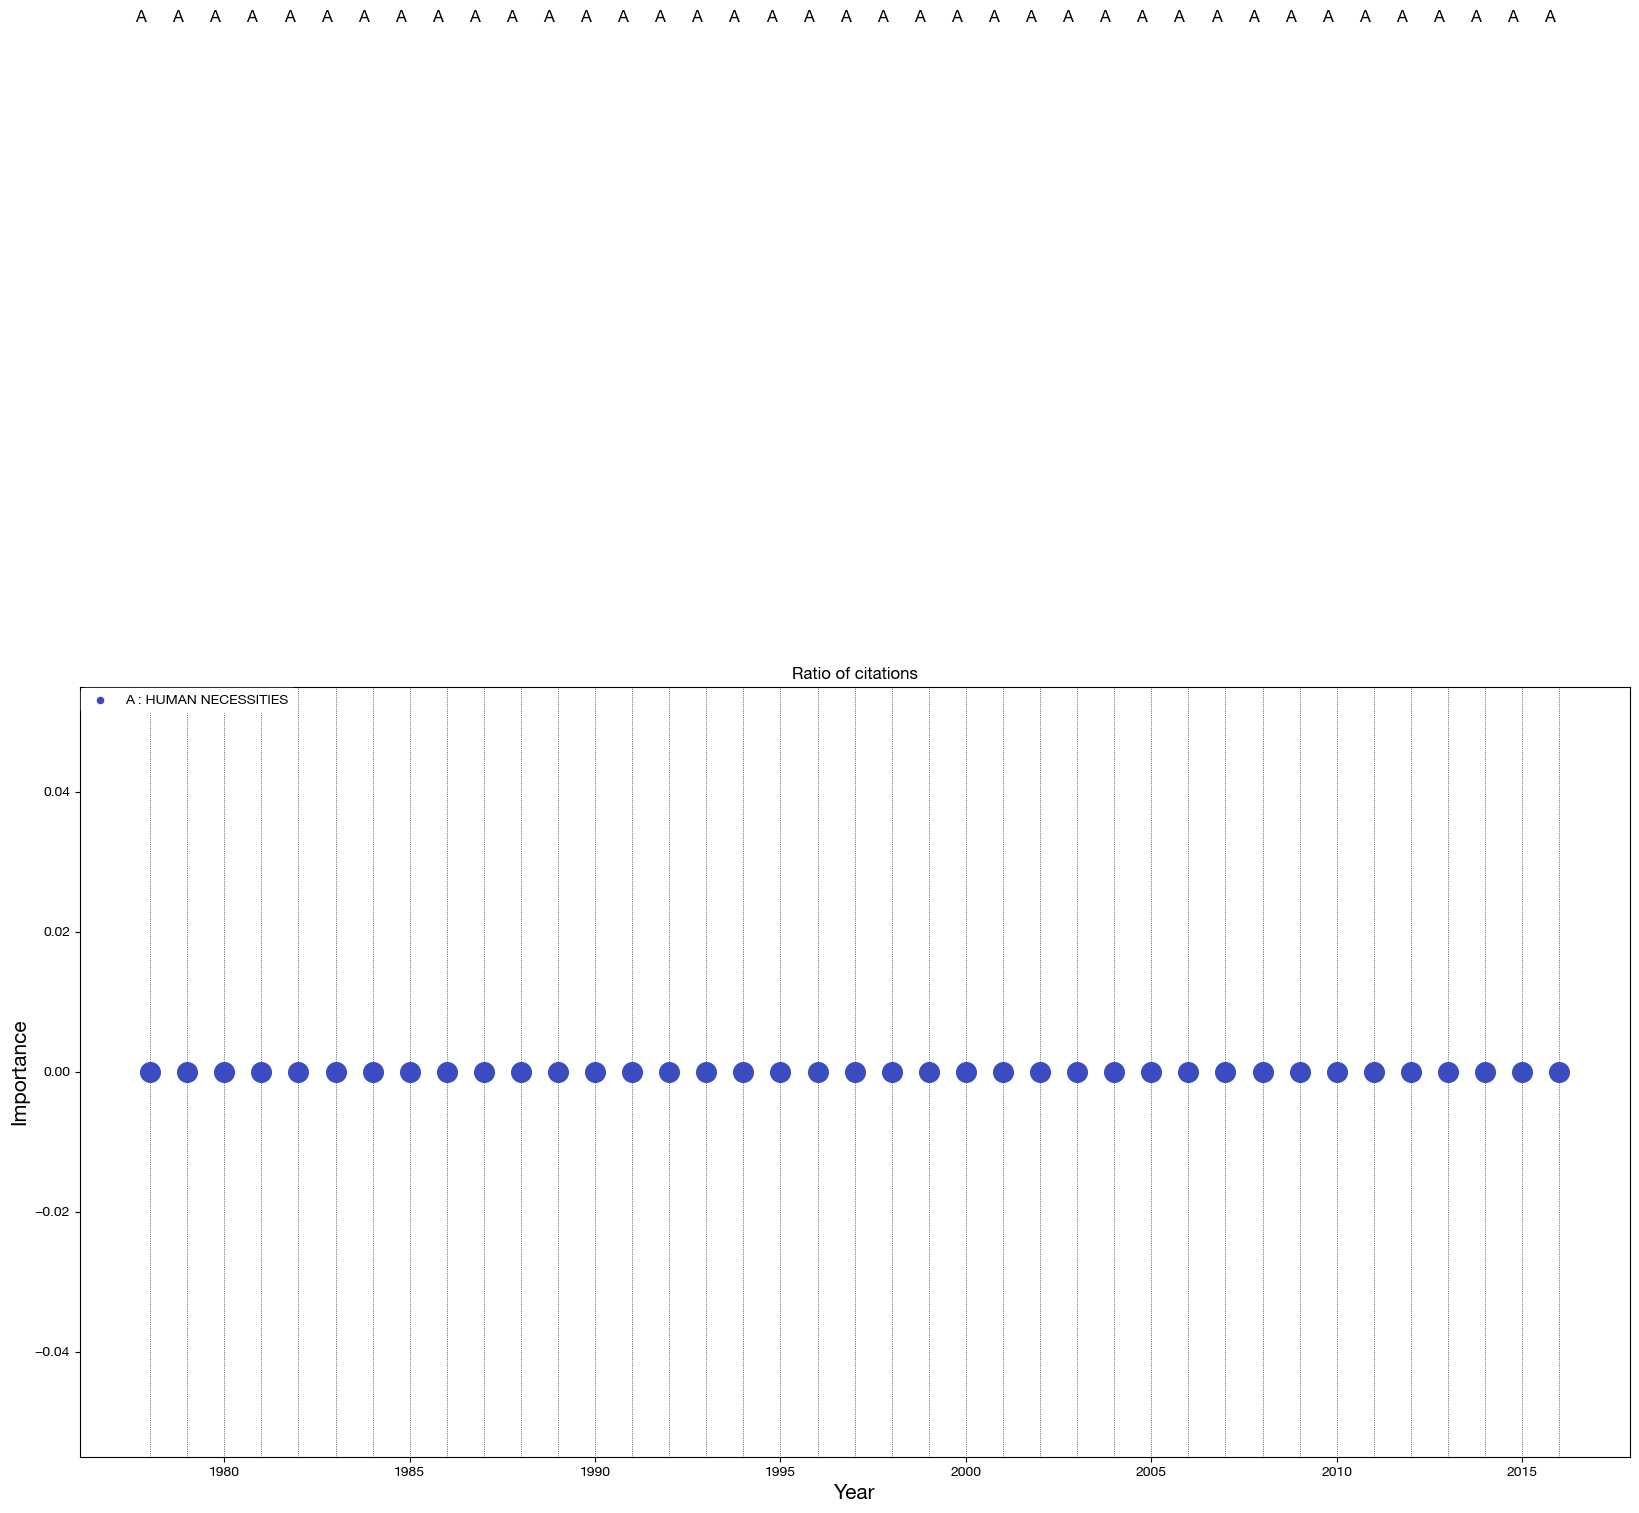

In [3027]:
plt.figure(figsize=(20, 10))
Dates_plotting = np.arange(min(np.array(Present_Dates_Cit).astype(int)), max(np.array(Present_Dates_Cit).astype(int)) + 1) # Dates for plotting
Colors = pl.cm.coolwarm(np.linspace(0, 1, len(Present_IPCs))) # Colors for plotting

Most_Cited = []
for i in range(len(Present_Dates_Cit)):
    Most_Cited.append(list(Present_IPCs_Keys.keys())[np.argmax(Storing_array.T[i])])

for k in range(len(Present_IPCs_Keys)):
    if str(list(Present_IPCs_Keys.keys())[k]) in Most_Cited: # Filtering only the most relevant
        translated = str(translate_ipc(list(Present_IPCs_Keys.keys())[k])[0])[:22] # Reducing to 22 characters
        plt.scatter(Dates_plotting, Storing_array[k], color=Colors[k], s=20, label=f'{list(Present_IPCs_Keys.keys())[k]} : {translated}')

for k in range(len(Dates_plotting)):
    plt.axvline(x=Dates_plotting[k], color='black', linestyle=':', linewidth=0.5)
    highest_point = max(Storing_array[:, k])  # Get the highest point for this instance
    plt.text(Dates_plotting[k]-0.4, highest_point+0.15, Most_Cited[k], fontsize=12, zorder=20)
    plt.scatter(Dates_plotting[k], highest_point, color=Colors[Present_IPCs_Keys[Most_Cited[k]]], s=200, zorder=10)  # Add a point at the highest point and set zorder to 10
    
plt.legend(loc='upper left', borderaxespad=0.1, fancybox=True, facecolor='white', frameon=True, framealpha=1, edgecolor='white') 
plt.title('Ratio of citations')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.show()

# Graphing normalised

In [3117]:
graph = ig.Graph(directed=True)
graph.add_vertices(Present_IPCs)
graph.add_edges(list(dict(Data[['Source IPC','Target IPC']].value_counts()).keys()))
graph.simplify() # Remove self loops
to_delete_ids = [v.index for v in graph.vs if v.degree() == 0] # Delete isolated nodes
graph.delete_vertices(to_delete_ids)

# Adding weights
Counts_prelim = dict(Data[['Source IPC','Target IPC']].value_counts())
graph.es['weight'] = list(Counts_prelim.values())

communities = graph.community_edge_betweenness(weights=graph.es['weight'])
communities = communities.as_clustering()
bridges = graph.bridges()

in_degrees = graph.degree(mode='in')
max_in_degrees = max(in_degrees)

##### Normalising

In [3129]:
# Tables
IPC_counts = pd.DataFrame(list(zip(list(dict(Data['Source IPC'].value_counts()).keys()),list(dict(Data['Source IPC'].value_counts()).values()))),columns=[['IPC','Count']])
IPC_counts.to_clipboard()
IPC_counts = pd.read_clipboard()
IPC_in_degrees = pd.DataFrame(list(zip(list(graph.vs['name']),list(in_degrees))),columns=[['IPC','In Degrees']])
IPC_in_degrees.to_clipboard()
IPC_in_degrees = pd.read_clipboard()
IPC_together = IPC_counts.merge(IPC_in_degrees, left_on='IPC', right_on='IPC')
IPC_together = IPC_together[['Count','In Degrees']].astype(int)

Count_Degree_Ratio = []
for i in range(len(IPC_together)):
    Count_Degree_Ratio.append(IPC_together['In Degrees'][i]/IPC_together['Count'][i])
    
graph.vs['CDR'] = np.array(Count_Degree_Ratio).astype(float)
max_CDR = max(graph.vs['CDR'])

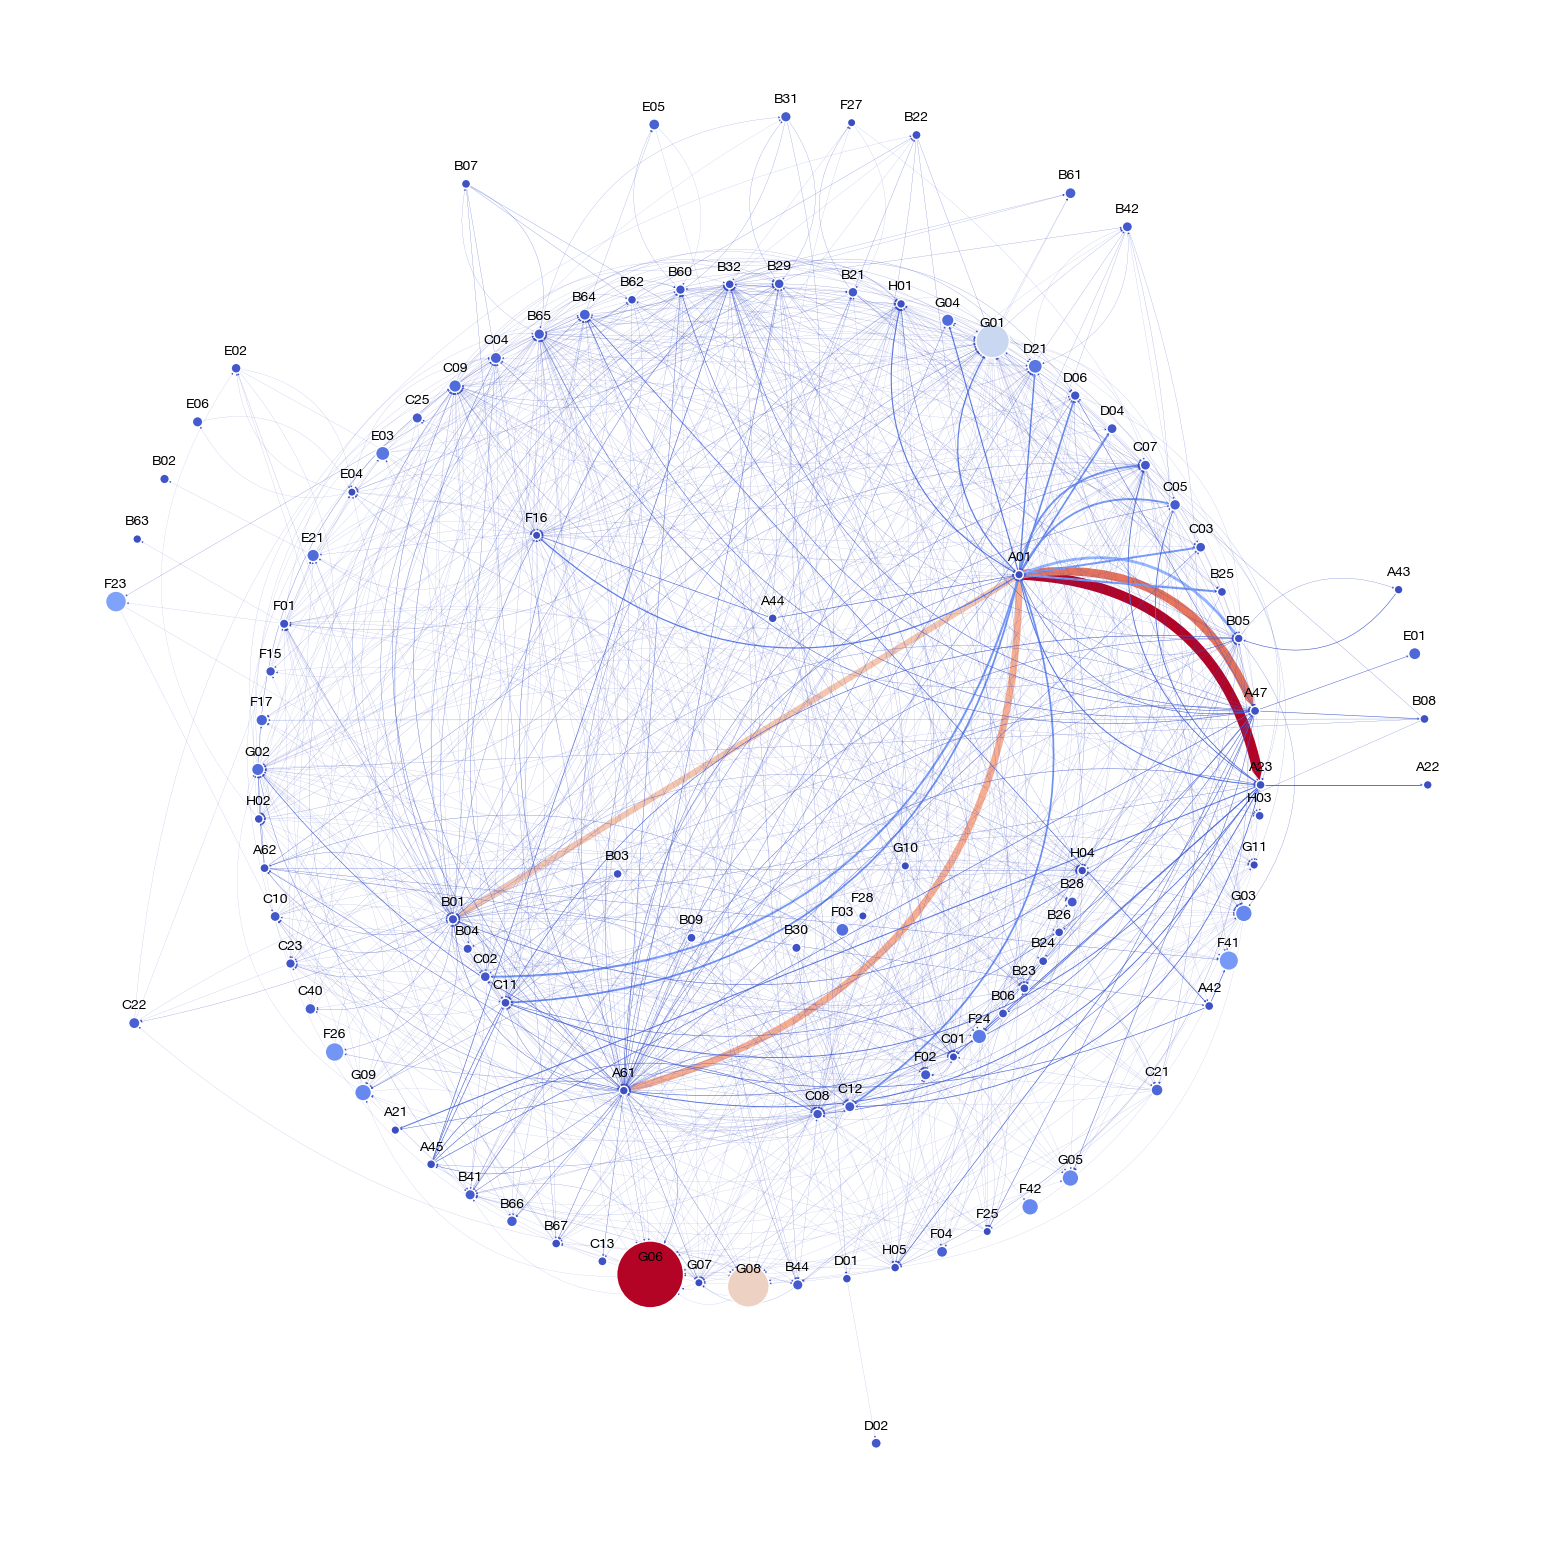

In [3132]:
# Define a colormap for node colors
colormap = plt.cm.get_cmap('coolwarm')  # Choose any colormap you like

fig, ax = plt.subplots(figsize=(5, 5))

ig.plot(
    graph,
    layout=graph.layout(layout='reingold_tilford_circular'),
    target=ax,
    vertex_size=[s * 0.05 + 0.05 for s in graph.vs['CDR']],
    mark_groups=True,
    vertex_frame_width=1.0,
    vertex_frame_color='white',
    vlabel_size=10.0,
    vertex_color=[colormap(d/max_CDR) for d in graph.vs['CDR']],
    edge_width=[w*0.01 + 0.05 for w in graph.es['weight']],
    vertex_label_color='white',
    edge_color=[colormap(w/max(graph.es['weight'])) for w in graph.es['weight']],
    edge_arrow_size=[w*0.000005 + 0.001 for w in graph.es['weight']]
)

layout = graph.layout(layout='reingold_tilford_circular')
for v, label in zip(layout, graph.vs["name"]):
    ax.text(v[0], v[1]+0.1, label, color='black', fontsize=10, ha='center', va='center')

fig.set_size_inches(20, 20)
plt.show()

In [3051]:
translate_ipc('G06')

['COMPUTING; CALCULATING OR COUNTING']

# Graphing Normalised Yearly

In [26]:
Storing_array = np.zeros((len(Present_IPCs_Keys),len(Present_Dates_Cit))) # Initialising empty storing array

range_y = 1 # Select 5 years

for y in tqdm(range(len(Present_Dates_Pat)-range_y)):
    
    Years_Selected = Present_Dates_Pat[y:y+range_y]
    Data_Y = Data.loc[Data['Source Patent Year'].isin(Years_Selected)]

    # Graphing normalised

    graph = ig.Graph(directed=True)
    graph.add_vertices(Present_IPCs)
    graph.add_edges(list(dict(Data_Y[['Source IPC','Target IPC']].value_counts()).keys()))
    graph.simplify() # Remove self loops
    to_delete_ids = [v.index for v in graph.vs if v.degree() == 0] # Delete isolated nodes
    graph.delete_vertices(to_delete_ids)

    # Adding weights
    Counts_prelim = dict(Data_Y[['Source IPC','Target IPC']].value_counts())
    graph.es['weight'] = list(Counts_prelim.values())

    in_degrees = graph.degree(mode='in')
    max_in_degrees = max(in_degrees)

    ##### Normalising

    # Tables
    IPC_counts = pd.DataFrame(list(zip(list(dict(Data_Y['Source IPC'].value_counts()).keys()),list(dict(Data_Y['Source IPC'].value_counts()).values()))),columns=[['IPC','Count']])
    IPC_counts.to_clipboard()
    IPC_counts = pd.read_clipboard()
    IPC_in_degrees = pd.DataFrame(list(zip(list(graph.vs['name']),list(in_degrees))),columns=[['IPC','In Degrees']])
    IPC_in_degrees.to_clipboard()
    IPC_in_degrees = pd.read_clipboard()
    IPC_together = IPC_counts.merge(IPC_in_degrees, left_on='IPC', right_on='IPC')
    IPC_together = IPC_together[['Count','In Degrees']].astype(int)

    Count_Degree_Ratio = []
    for i in range(len(IPC_together)):
        Count_Degree_Ratio.append(IPC_together['In Degrees'][i]/IPC_together['Count'][i])

    graph.vs['CDR'] = np.array(Count_Degree_Ratio).astype(float)
    max_CDR = max(graph.vs['CDR'])

    extract_information = list(zip(list(graph.vs['name']),list(graph.vs['CDR'])))

    # Storing all values into the storing array
    for j in range(len(extract_information)):
        Storing_array[Present_IPCs_Keys[extract_information[j][0]]][y] = extract_information[j][1]
        
epsilon = 0.001 # To avoid error in logarithmic plot
Storing_array[Storing_array == 0] = epsilon
Storing_array = np.log(Storing_array)

100%|███████████████████████████████████████████| 30/30 [00:01<00:00, 25.61it/s]


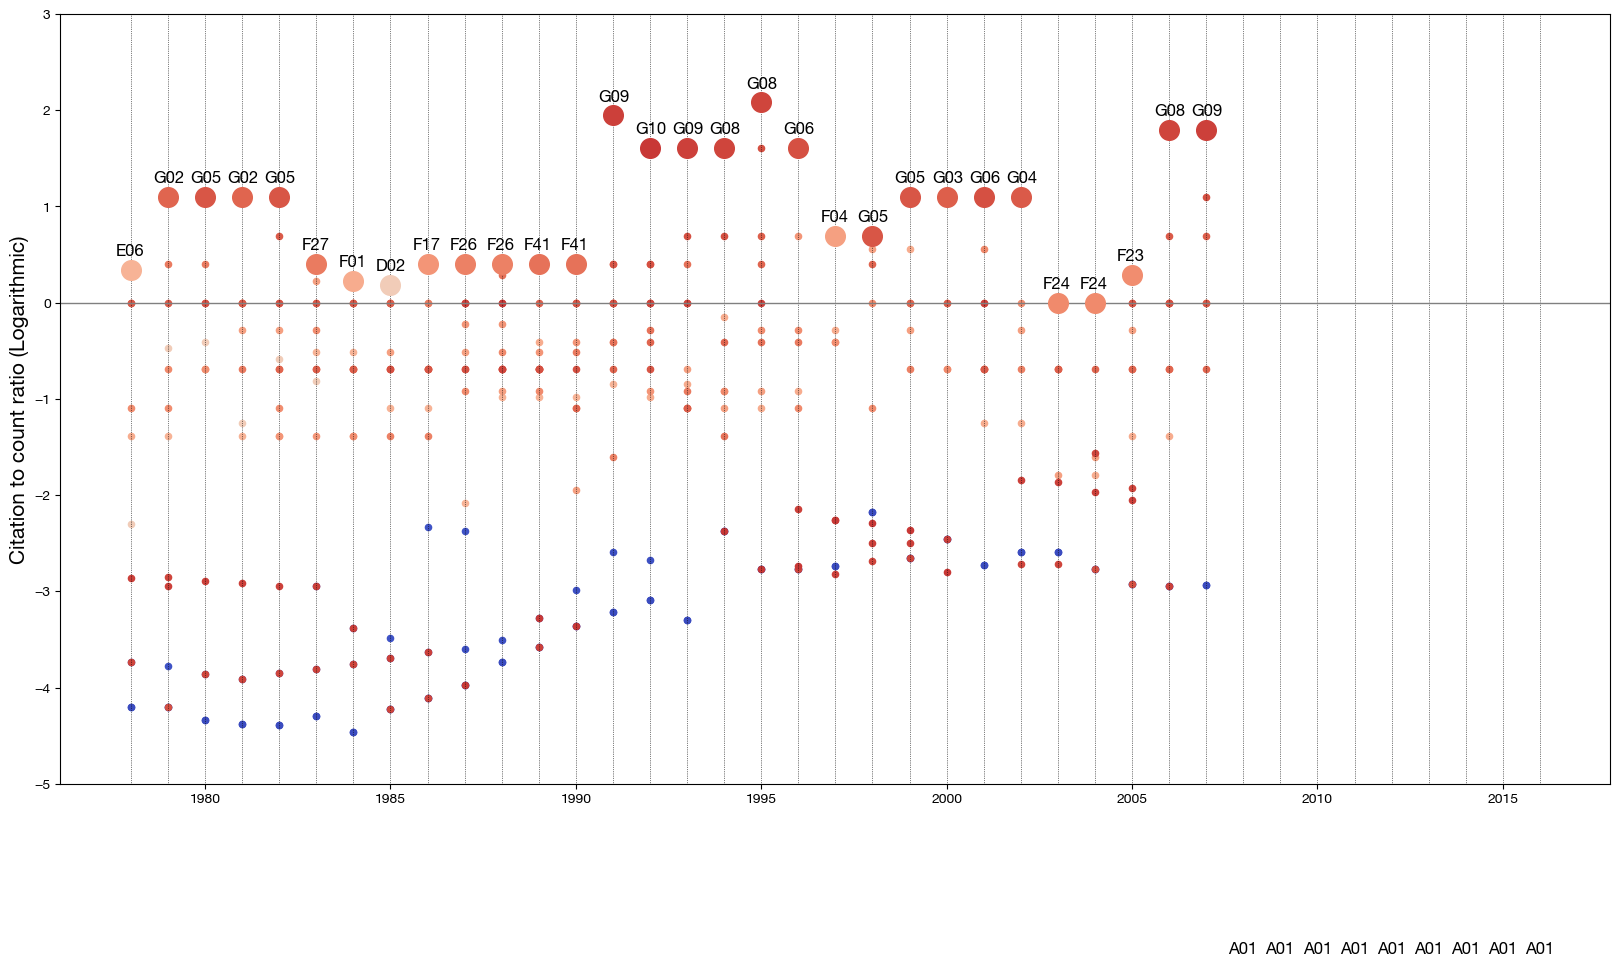

In [27]:
plt.figure(figsize=(20, 10))
Dates_plotting = np.arange(min(np.array(Present_Dates_Cit).astype(int)), max(np.array(Present_Dates_Cit).astype(int)) + 1) # Dates for plotting
Colors = pl.cm.coolwarm(np.linspace(0, 1, len(Present_IPCs))) # Colors for plotting

Most_Cited = []
Least_Cited = []
for i in range(len(Present_Dates_Cit)):
    Most_Cited.append(list(Present_IPCs_Keys.keys())[np.argmax(Storing_array.T[i])])
    Least_Cited.append(list(Present_IPCs_Keys.keys())[np.argmin(Storing_array.T[i])])

for k in range(len(Present_IPCs_Keys)):
    if str(list(Present_IPCs_Keys.keys())[k]) in Most_Cited: # Filtering only the most relevant
        translated = str(translate_ipc(list(Present_IPCs_Keys.keys())[k])[0])[:22] # Reducing to 22 characters
        plt.scatter(Dates_plotting, Storing_array[k], color=Colors[k], s=20, label=f'{list(Present_IPCs_Keys.keys())[k]} : {translated}')
    if str(list(Present_IPCs_Keys.keys())[k]) in Least_Cited: # Filtering only the most relevant
        translated = str(translate_ipc(list(Present_IPCs_Keys.keys())[k])[0])[:22] # Reducing to 22 characters
        plt.scatter(Dates_plotting, Storing_array[k], color=Colors[k], s=20, label=f'{list(Present_IPCs_Keys.keys())[k]} : {translated}')

for k in range(len(Dates_plotting)):
    plt.axvline(x=Dates_plotting[k], color='black', linestyle=':', linewidth=0.5)
    highest_point = max(Storing_array[:, k])  # Get the highest point for this instance
    
    plt.text(Dates_plotting[k]-0.4, highest_point+0.15, Most_Cited[k], fontsize=12, zorder=20)
    plt.scatter(Dates_plotting[k], highest_point, color=Colors[Present_IPCs_Keys[Most_Cited[k]]], s=200, zorder=10)  # Add a point at the highest point and set zorder to 10
    lowest_point = min(Storing_array[:, k])  # Get the highest point for this instance

#plt.legend(loc='upper left', borderaxespad=0.1, fancybox=True, facecolor='white', frameon=True, framealpha=1, edgecolor='white') 
#plt.title('Ratio of citations')
#plt.xlabel('Year', fontsize=15)
plt.axhline(y=0, color='grey', linestyle='-', linewidth=1)
plt.ylabel('Citation to count ratio (Logarithmic)', fontsize=15)
plt.ylim(-5,3)
#plt.yscale("log");
plt.show()

# Diversity

In [191]:
graph = ig.Graph(directed=True)
graph.add_vertices(Present_IPCs)
graph.add_edges(list(dict(Data[['Source IPC','Target IPC']].value_counts()).keys()))
graph.simplify() # Remove self loops
to_delete_ids = [v.index for v in graph.vs if v.degree() == 0] # Delete isolated nodes
graph.delete_vertices(to_delete_ids)

# Adding weights
Counts_prelim = dict(Data[['Source IPC','Target IPC']].value_counts())
graph.es['weight'] = list(Counts_prelim.values())

communities = graph.community_edge_betweenness(weights=graph.es['weight'])
communities = communities.as_clustering()
bridges = graph.bridges()

in_degrees = graph.degree(mode='in')
max_in_degrees = max(in_degrees)

##### Diversity

In [192]:
def get_div_mes(IPC_chosen):
    
    '''Diversity Measure'''
    
    IPC_spreads_all = dict(zip(list(Present_IPCs),np.zeros(len(Present_IPCs))))
    IPC_spreads_all = dict(zip(list(Present_IPCs),np.zeros(len(Present_IPCs))))
    IPC_spread_spec = Data[Data['Source IPC'] == IPC_chosen]['Target IPC'].value_counts()[1:] 
    IPC_spread_spec_keys = list(dict(IPC_spread_spec).keys())
    IPC_spread_spec_values = list(dict(IPC_spread_spec).values())
    for i in range(len(IPC_spread_spec_keys)):
        IPC_spreads_all[IPC_spread_spec_keys[i]] = np.log(IPC_spread_spec_values[i])
    diversity_spread = dict(sorted(IPC_spreads_all.items(), key = lambda x:x[1], reverse=True )) # The plot of diversity
    best_fit_grad = list(np.poly1d(np.polyfit(np.arange(len(list(diversity_spread.values()))), list(diversity_spread.values()), 1)))[0] # Best fit line
    
    return (abs(1/(best_fit_grad+1))-1)*100, diversity_spread

In [193]:
diversity_measures = []

for k in range(len(list(graph.vs['name']))):
    IPC_chosen = list(graph.vs['name'])[k]
    diversity_measures.append(get_div_mes(IPC_chosen)[0])
    
graph.vs['div'] = diversity_measures
max_div = max(graph.vs['div'])

In [194]:
associations_div_mes = list(zip(list(graph.vs['name']),list(diversity_measures)))

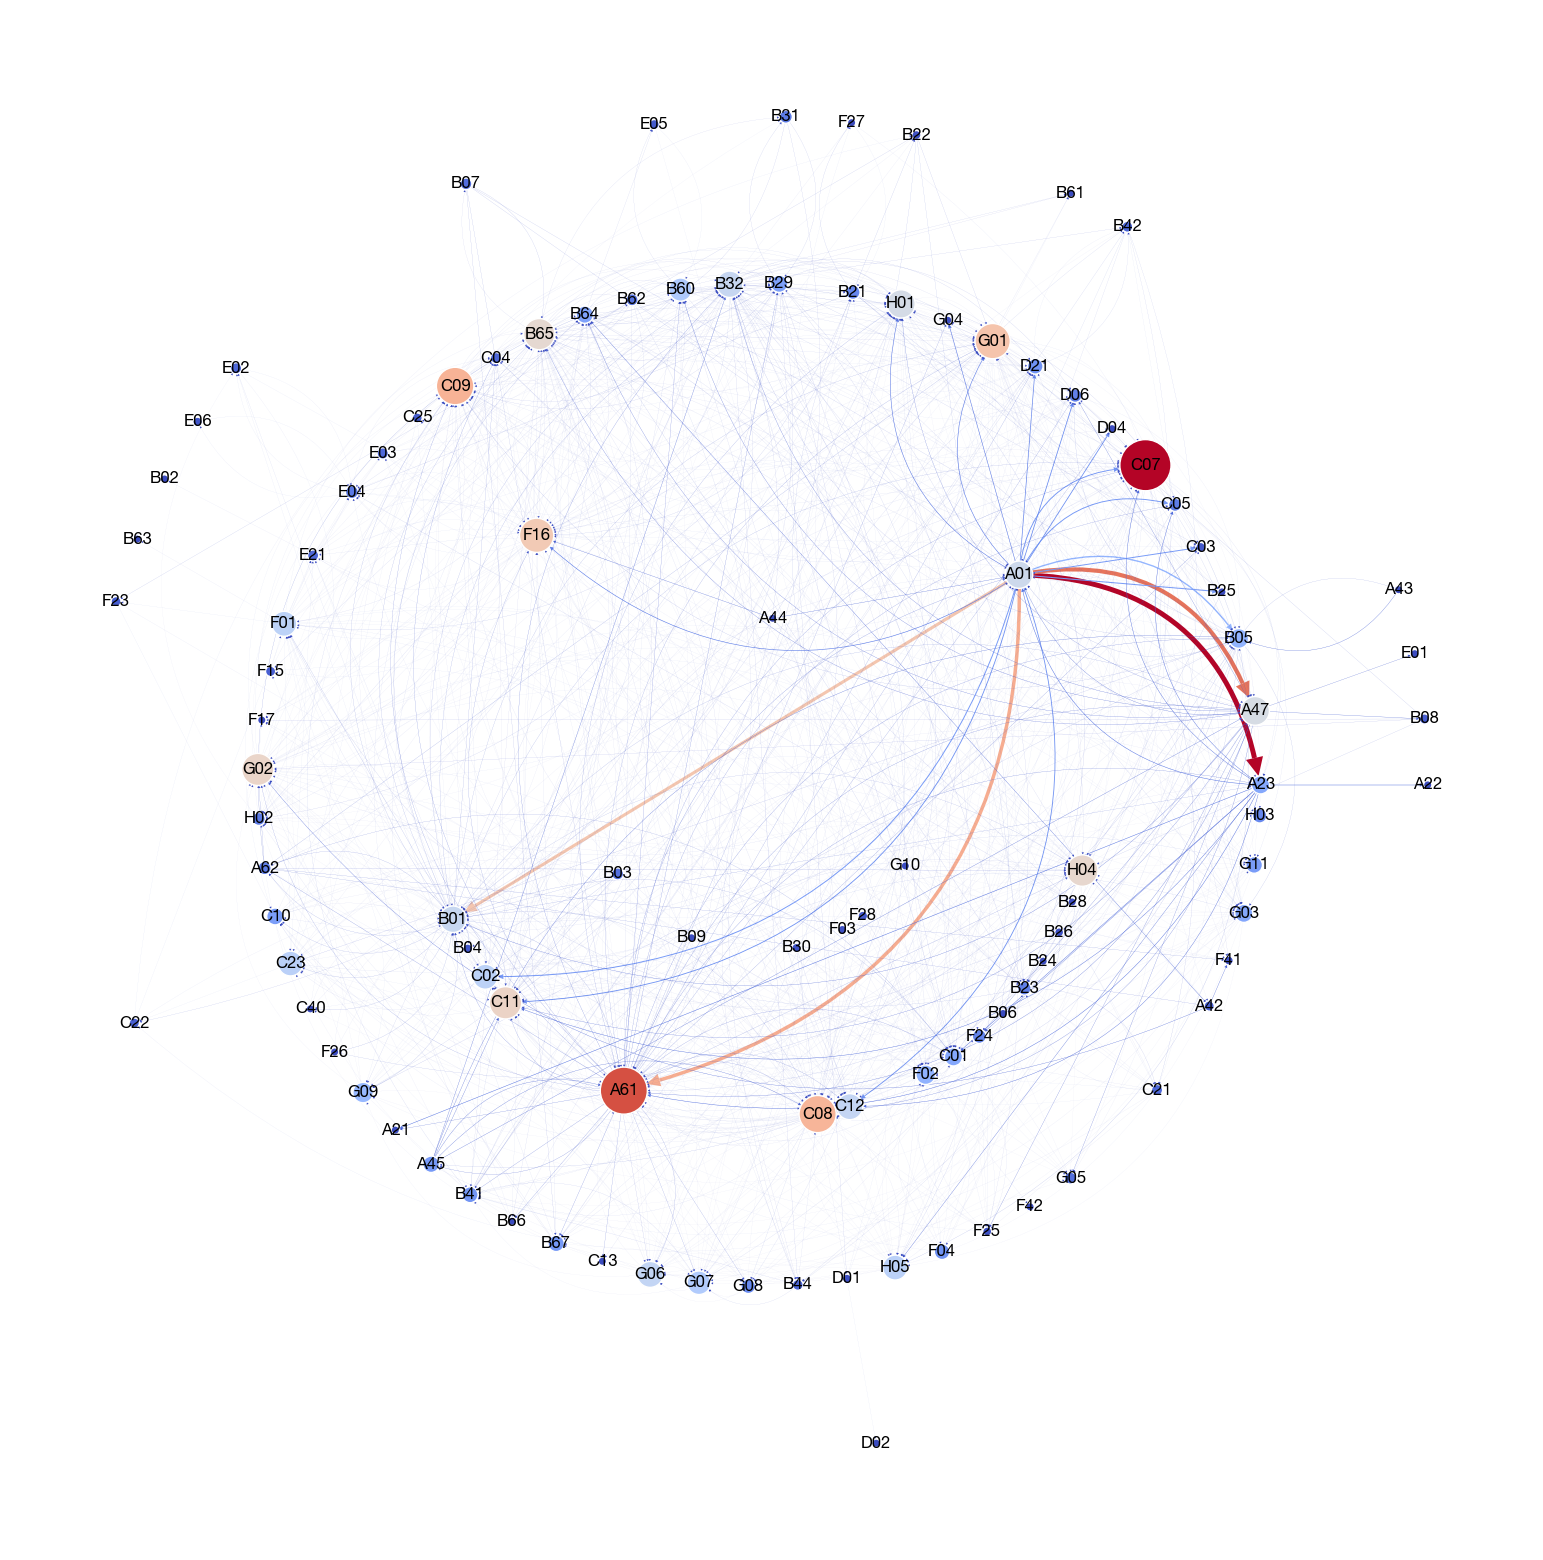

In [195]:
# Define a colormap for node colors
colormap = plt.cm.get_cmap('coolwarm')  # Choose any colormap you like

fig, ax = plt.subplots(figsize=(5, 5))

ig.plot(
    graph,
    layout=graph.layout(layout='reingold_tilford_circular'),
    target=ax,
    vertex_size=[s * 0.1 + 0.05 for s in graph.vs['div']],
    mark_groups=True,
    vertex_frame_width=1.0,
    vertex_frame_color='White',
    vertex_label=graph.vs["name"],
    vlabel_size=10.0,
    vertex_color=[colormap(d/max_div) for d in graph.vs['div']],
    edge_width=[w*0.005 + 0.01 for w in graph.es['weight']],
    vertex_label_color='White',
    edge_color=[colormap(w/max(graph.es['weight'])) for w in graph.es['weight']],
    edge_arrow_size=[w*0.00001 + 0.001 for w in graph.es['weight']]
)

fig.set_size_inches(20, 20)
plt.show()

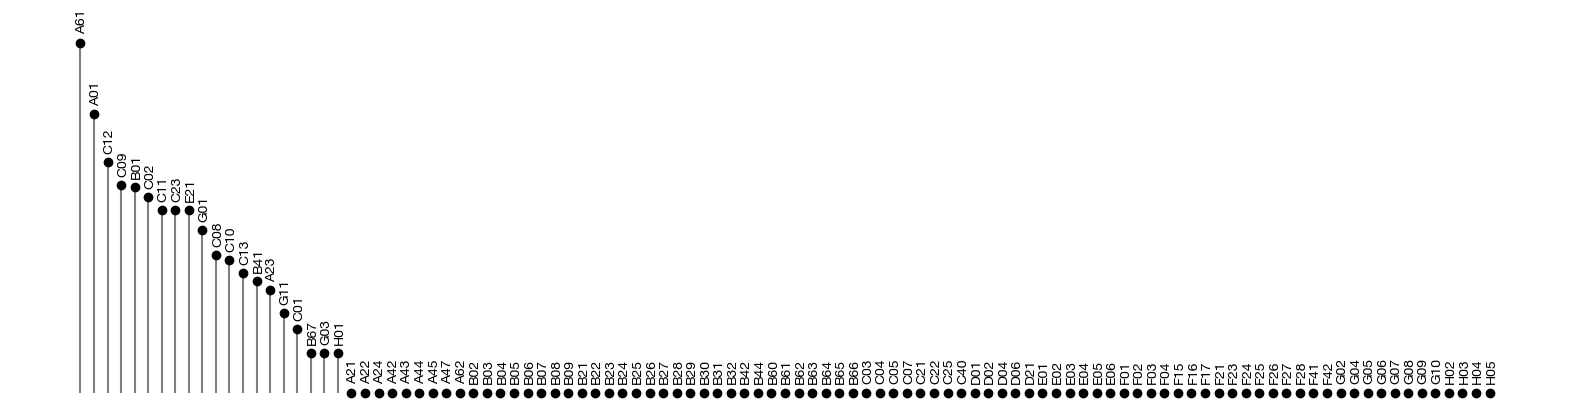

In [246]:
IPC_s = 'C07'
diversity_measure = np.array(get_div_mes(IPC_s)[0])
plt.figure(figsize=(20,5))

func_x = np.arange(len(list(get_div_mes(IPC_s)[1].values())))
func_y = list(get_div_mes(IPC_s)[1].values())
names = list(get_div_mes(IPC_s)[1].keys())
plt.scatter(func_x,func_y, color='black')

i=0
for x, y in zip(func_x, func_y):
    plt.vlines(x, 0, y, linestyle='-', colors='black', alpha=0.5)
    plt.text(x-0.3, y+0.2, names[i], rotation=90)
    i+=1

plt.axis('off')
#plt.legend(frameon=False,fontsize=12)
plt.show()

In [252]:
topx=10
top_div = dict(sorted(dict(zip(graph.vs['name'],graph.vs['div'])).items(), key=lambda x:x[1], reverse=True)[:topx])
top_div_IPCs = list(top_div.keys())
top_div_values = list(top_div.values())

i=0
for ipc in top_div_IPCs:
    print(sorted(graph.vs['div'],reverse=True)[i])
    i+=1
    print(ipc)
    print(list(translate_ipc(ipc)))

2.5603408404572425
C07
['ORGANIC CHEMISTRY']
2.3135385299559497
A61
['MEDICAL OR VETERINARY SCIENCE; HYGIENE']
1.7423464526559629
C09
['DYES; PAINTS; POLISHES; NATURAL RESINS; ADHESIVES; COMPOSITIONS NOT OTHERWISE PROVIDED FOR; APPLICATIONS OF MATERIALS NOT OTHERWISE PROVIDED FOR']
1.7209192845861088
C08
['ORGANIC MACROMOLECULAR COMPOUNDS; THEIR PREPARATION OR CHEMICAL WORKING-UP; COMPOSITIONS BASED THEREON']
1.6065492964713046
G01
['MEASURING; TESTING']
1.5497573043907087
F16
['ENGINEERING ELEMENTS OR UNITS; GENERAL MEASURES FOR PRODUCING AND MAINTAINING EFFECTIVE FUNCTIONING OF MACHINES OR INSTALLATIONS; THERMAL INSULATION IN GENERAL']
1.431663213183576
C11
['ANIMAL OR VEGETABLE OILS, FATS, FATTY SUBSTANCES OR WAXES; FATTY ACIDS THEREFROM; DETERGENTS; CANDLES']
1.4180845984377743
G02
['OPTICS']
1.3817236674568356
H04
['ELECTRIC COMMUNICATION TECHNIQUE']
1.3662762793297922
B65
['CONVEYING; PACKING; STORING; HANDLING THIN OR FILAMENTARY MATERIAL']


In [231]:
bottomx=10
bottom_div = dict(sorted(dict(zip(graph.vs['name'],graph.vs['div'])).items(), key=lambda x:x[1], reverse=True)[-bottomx:])
bottom_div_IPCs = list(bottom_div.keys())
bottom_div_values = list(bottom_div.values())

for ipc in botto_div_IPCs:
    print(translate_ipc(ipc))

['COMBINATORIAL TECHNOLOGY']
['YARNS; MECHANICAL FINISHING OF YARNS OR ROPES; WARPING OR BEAMING']
['BRAIDING; LACE-MAKING; KNITTING; TRIMMINGS; NON-WOVEN FABRICS']
['CONSTRUCTION OF ROADS, RAILWAYS, OR BRIDGES']
['STORING OR DISTRIBUTING GASES OR LIQUIDS']
['DRYING']
['FURNACES; KILNS, OVENS OR RETORTS']
['AMMUNITION; BLASTING']
['HOROLOGY']
['MUSICAL INSTRUMENTS; ACOUSTICS']


# Evolution of patents

In [2224]:
Patents_ind = (Patents[['Application','Patent Year']].drop_duplicates()).astype(str)
year_selected = 2001
Patents_cumu = 0
Patents_cumu_ar = []
Patents_increase = 0
Patents_increase_ar = []

for i in range(len(Present_Dates_Pat)):
    Patents_increase = len(Patents_ind.loc[Patents_ind['Patent Year'] == str(Present_Dates_Pat[i])])
    Patents_cumu += Patents_increase
    Patents_increase_ar.append(Patents_increase)
    Patents_cumu_ar.append(Patents_cumu)

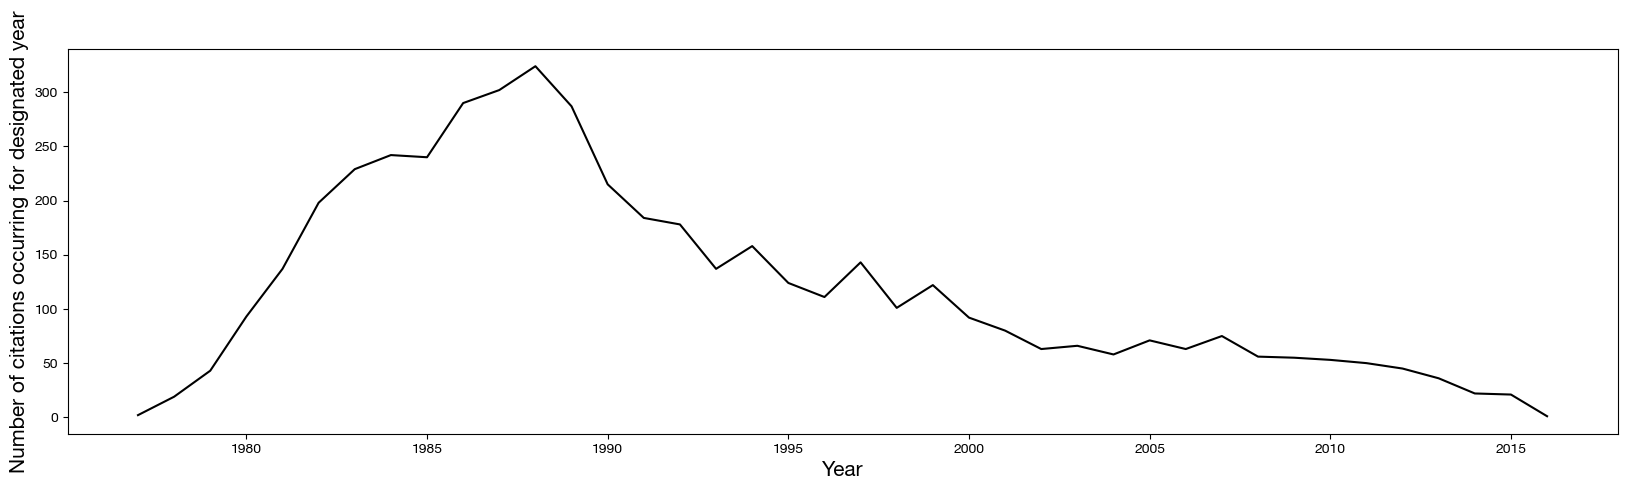

In [2249]:
plt.figure(figsize=(20, 5))
Dates_plotting = np.arange(min(np.array(Present_Dates_Pat).astype(int)), max(np.array(Present_Dates_Pat).astype(int)) + 1) # Dates for plotting
Colors = pl.cm.coolwarm(np.linspace(0, 1, len(Present_IPCs))) # Colors for plotting

#plt.plot(Dates_plotting,Patents_cumu_ar,color='black')
plt.plot(Dates_plotting,Patents_increase_ar,color='black')

#plt.legend(loc='upper right', borderaxespad=0.1, fancybox=True, facecolor='white', frameon=True, framealpha=1, edgecolor='white') 
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of citations occurring for designated year', fontsize=15)
plt.show()

# Normalised share of patents

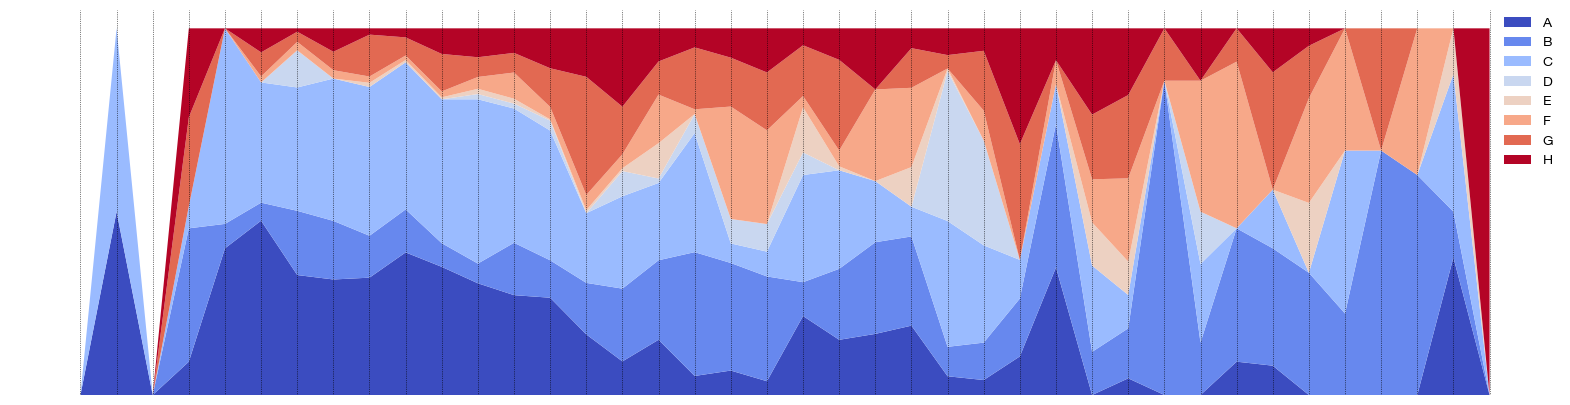

In [2352]:
Storing_array = np.zeros((len(Present_IPCs_Keys),len(Present_Dates_Pat))) # Initialising empty storing array

for i in range(len(Present_Dates_Pat)):
    
    # Creating IPC Citation relationships
    Data_select = Data.loc[Data['Citation Year'] == Present_Dates_Pat[i]] # Selecting all patents created in specific year
    Counts_prelim = dict(Data_select[['Source IPC','Target IPC']].value_counts()) # Converting multiple citation counts into weights
    Counts = [(key[0], key[1], value) for key, value in Counts_prelim.items()] # Formatted correctly
    
    # Creating graph
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(Counts)
    graph.remove_edges_from(nx.selfloop_edges(graph)) # NOT ACCOUNTING FOR SELF CITATIONS
    extract_information = list(graph.in_degree(weight='weight')) # Accounting for the counts
    
    # Storing all values into the storing array
    for j in range(len(extract_information)):
        Storing_array[Present_IPCs_Keys[extract_information[j][0]]][i] = extract_information[j][1]

for i in range(len(Storing_array.T)):
    if np.sum(Storing_array.T[i]) != 0:
        Storing_array.T[i] = Storing_array.T[i]/(np.sum(Storing_array.T[i]))
        
plt.figure(figsize=(20, 5))
Dates_plotting = np.arange(min(np.array(Present_Dates_Pat).astype(int)), max(np.array(Present_Dates_Pat).astype(int)) + 1) # Dates for plotting
Colors = pl.cm.coolwarm(np.linspace(0, 1, len(Present_IPCs))) # Colors for plotting

Most_Cited = []
for i in range(len(Present_Dates_Pat)):
    Most_Cited.append(list(Present_IPCs_Keys.keys())[np.argmax(Storing_array.T[i])])

plt.stackplot(Dates_plotting,Storing_array,labels=Present_IPCs_Keys.keys(),colors = Colors)

for k in range(len(Dates_plotting)):
    plt.axvline(x=Dates_plotting[k], color='black', linestyle=':', linewidth=0.5)
    #highest_point = 2  # Get the highest point for this instance
    #plt.text(Dates_plotting[k], 1+0.01, Most_Cited[k], fontsize=12, zorder=20, color='Black')  # Adjust the y coordinate to move the text above the highest point and set zorder to 10
    #plt.scatter(Dates_plotting[k], highest_point, color=Colors[Present_IPCs_Keys[Most_Cited[k]]], s=200, zorder=10)  # Add a point at the highest point and set zorder to 10

plt.legend(loc='upper right', borderaxespad=0.1, fancybox=True, facecolor='white', frameon=True, framealpha=1, edgecolor='white') 
#plt.xlabel('Year', fontsize=15)
#plt.ylabel('Number of citations occurring for designated year', fontsize=15)
plt.axis('off')
plt.show()

# 3D Plotting

In [821]:
Data['Source IPC'] = Data['Source IPC'].str.replace(" ", "")
Data['Target IPC'] = Data['Target IPC'].str.replace(" ", "")
Patents['IPC'] = Patents['IPC'].str.replace(" ", "")

In [822]:
Citations_unfiltered = Citations_raw.rename(columns={'source':'Source','target':'Target','time':'Citation Year'})

In [823]:
graph = nx.Graph()
graph.add_edges_from(list(zip(list(Citations_unfiltered['Source']),list(Citations_unfiltered['Target']))))

In [824]:
all_patents = list(graph.nodes())

dates_for_patents = dict(list(zip(list(Citations_unfiltered['Source']),list((Citations_unfiltered['Citation Year'])))))
nx.set_node_attributes(graph, 1970, name="date")
nx.set_node_attributes(graph, dates_for_patents, name="date")

IPC_for_pat = Patents[['Application','IPC']].drop_duplicates()
IPC_for_pat = IPC_for_pat.groupby('Application')['IPC'].apply(', '.join).reset_index()
IPC_codes = dict(list(zip(list(IPC_for_pat['Application']),list(IPC_for_pat['IPC']))))
nx.set_node_attributes(graph, ' ', name="IPC")
nx.set_node_attributes(graph, IPC_codes, name="IPC")

graph_orig = graph
ccs = sorted(nx.connected_components(graph_orig), key=len, reverse=True)
largest_ccs = graph_orig.subgraph(ccs[0])
graph = largest_ccs

In [825]:
pos_spring = nx.spring_layout(graph)
pos = {list(graph.nodes())[i]: (list(dict(pos_spring).values())[i][0], list(nx.get_node_attributes(graph, 'date').values())[i], list(dict(pos_spring).values())[i][1]) for i in tqdm(range(len(graph.nodes)))}
nx.set_node_attributes(graph, pos, name="pos")

100%|███████████████████████████████████████| 287/287 [00:00<00:00, 1887.64it/s]


In [826]:
len(graph.nodes())

287

In [837]:
node_dates = nx.get_node_attributes(graph, name="date")

lowest_date_node = min(node_dates, key=node_dates.get)
highest_date_node = max(node_dates, key=node_dates.get)

path = nx.shortest_path(graph,source=lowest_date_node,target=highest_date_node)
path

['EP19820301775',
 'EP19880306205',
 'EP19790200303',
 'EP19810305267',
 'EP19840308397',
 'EP19880201833',
 'EP20170186891']

In [848]:
def network_plot_3D(G, angle, save):

    # extracting info
    pos = nx.get_node_attributes(G, 'pos')
    n = G.number_of_nodes()
    dates = list(nx.get_node_attributes(G, 'date').values())
    IPCs = list(nx.get_node_attributes(G, 'IPC').values())
    
    # get shortest path
    node_dates = nx.get_node_attributes(G, name="date")
    lowest_date_node = min(node_dates, key=node_dates.get)
    highest_date_node = max(node_dates, key=node_dates.get)
    path_nodes = nx.shortest_path(G,source=lowest_date_node,target=highest_date_node)
    
    with plt.style.context(('ggplot')):
        
        fig = plt.figure(figsize=(20,15))
        ax = fig.gca(projection='3d',facecolor='white')
        
        jcounter = 0
        for key, value in pos.items(): # nodes
            xi = value[0]
            yi = value[1]
            zi = value[2]
            relative_output = (10+10*G.degree(key)) # Highlight only those with known IPC
            #relative_output = (10+100*G.out_degree(key))/(1+10*abs(max(dates)-value[1])) 
            #if IPCs[jcounter] != 'N/A':
            ax.scatter(xi, yi, zi, c=value[1], norm=mpl.colors.Normalize(vmin=min(dates),vmax=max(dates)), cmap = 'coolwarm', s=relative_output, edgecolors='k', alpha=0.9, zorder=10) # Out degree since those CITE the most
                #ax.text(xi, yi, zi+0.1, s=IPCs[jcounter], c='white', fontsize=7, zorder=20)
            #else:
                #ax.scatter(xi, yi, zi, c=value[1], norm=mpl.colors.Normalize(vmin=min(dates),vmax=max(dates)), cmap = 'coolwarm', s=relative_output, edgecolors='k', alpha=0.45, zorder=10) # Out degree since those CITE the most
            
            ax.plot(np.array((xi,xi)), np.array((yi,yi)), np.array((-1,zi)), c='white', alpha=0.5, linewidth=0.5, linestyle=':')
            
            jcounter += 1
            
        c_selection = mpl.cm.coolwarm(np.linspace(0,1,int(abs(max(dates)-min(dates)))+1)) # Edge Colors
        
        for i,j in enumerate(G.edges()): # edges
            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
            
            if pos[j[0]][1] < 1970:
                print('occuring 1')
                ax.plot(x, np.array((1970, pos[j[1]][1])), z, c=c_selection[int(abs(pos[j[1]][1]-min(dates)))], alpha=0.1, linewidth=0.5)
            if pos[j[1]][1] < 1970:
                print('occuring 2')
                ax.plot(x, np.array((pos[j[0]][1], 1970)), z, c=c_selection[int(abs(pos[j[1]][1]-min(dates)))], alpha=0.1, linewidth=0.5)
            else:
                ax.plot(x, y, z, c=c_selection[int(abs(pos[j[1]][1]-min(dates)))], alpha=0.5, linewidth=0.5)
            #ax.quiver(x[1], y[1], z[1], x[0]-x[1], y[0]-y[1], z[0]-z[1], color=c_selection[int(abs(pos[j[1]][1]-min(dates)))], alpha=0.5, linewidth=0.5)
            
    # viewpoint
    #ax.axes.set_ylim3d(bottom=1970, top=2017) 
    ax.axes.set_zlim3d(bottom=-1, top=1) 
    
    ax.w_xaxis.set_pane_color((0.33, 0.33, 0.33, 1.0))
    ax.w_yaxis.set_pane_color((0.33, 0.33, 0.33, 1.0))
    ax.w_zaxis.set_pane_color((0.33, 0.33, 0.33, 1.0))
    
    ax.xaxis._axinfo["grid"]['color'] = mpl.colors.to_rgba('lightgrey', alpha=0.3)
    ax.yaxis._axinfo["grid"]['color'] = mpl.colors.to_rgba('lightgrey', alpha=0.3)
    ax.zaxis._axinfo["grid"]['color'] = mpl.colors.to_rgba('lightgrey', alpha=0.3)
    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=30))
    
    ax.set_xticks([])
    ax.set_zticks([])
    ax.set_xticklabels([])
    ax.set_zticklabels([])

    ax.set_box_aspect([1,3,1])
    ax.view_init(30, angle)
            
    if save is not False:
        file_dir = "/Users/joebacchus/Desktop/PLOTS4LATEX/plots"+str(angle)+".png"
        plt.savefig(file_dir, dpi=300)
        plt.close("all")
        print('Done.')
        
    plt.show()
    
    return

/var/folders/7f/r079rwbx56v6qwwwwxq2cpzw0000gn/T/ipykernel_37860/3898168961.py:18: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d',facecolor='white')


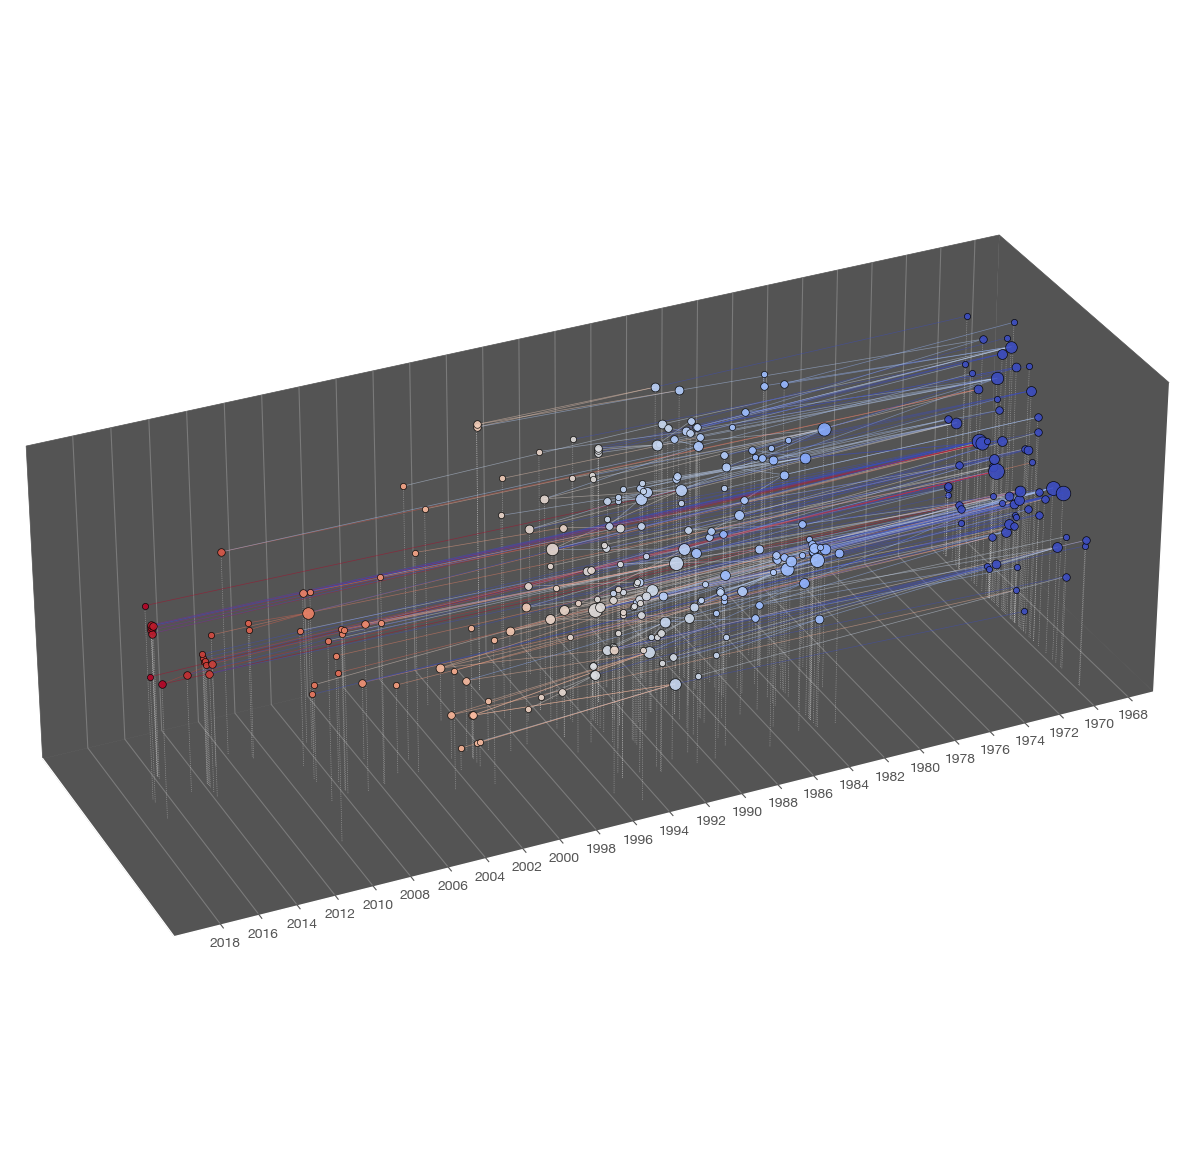

In [849]:
network_plot_3D(graph, 155, False)

# Visible clusters

In [777]:
S = [graph_orig.subgraph(c).copy() for c in nx.connected_components(graph_orig)]
S_sorted = sorted(S, key=lambda g: len(g.nodes()), reverse=True)

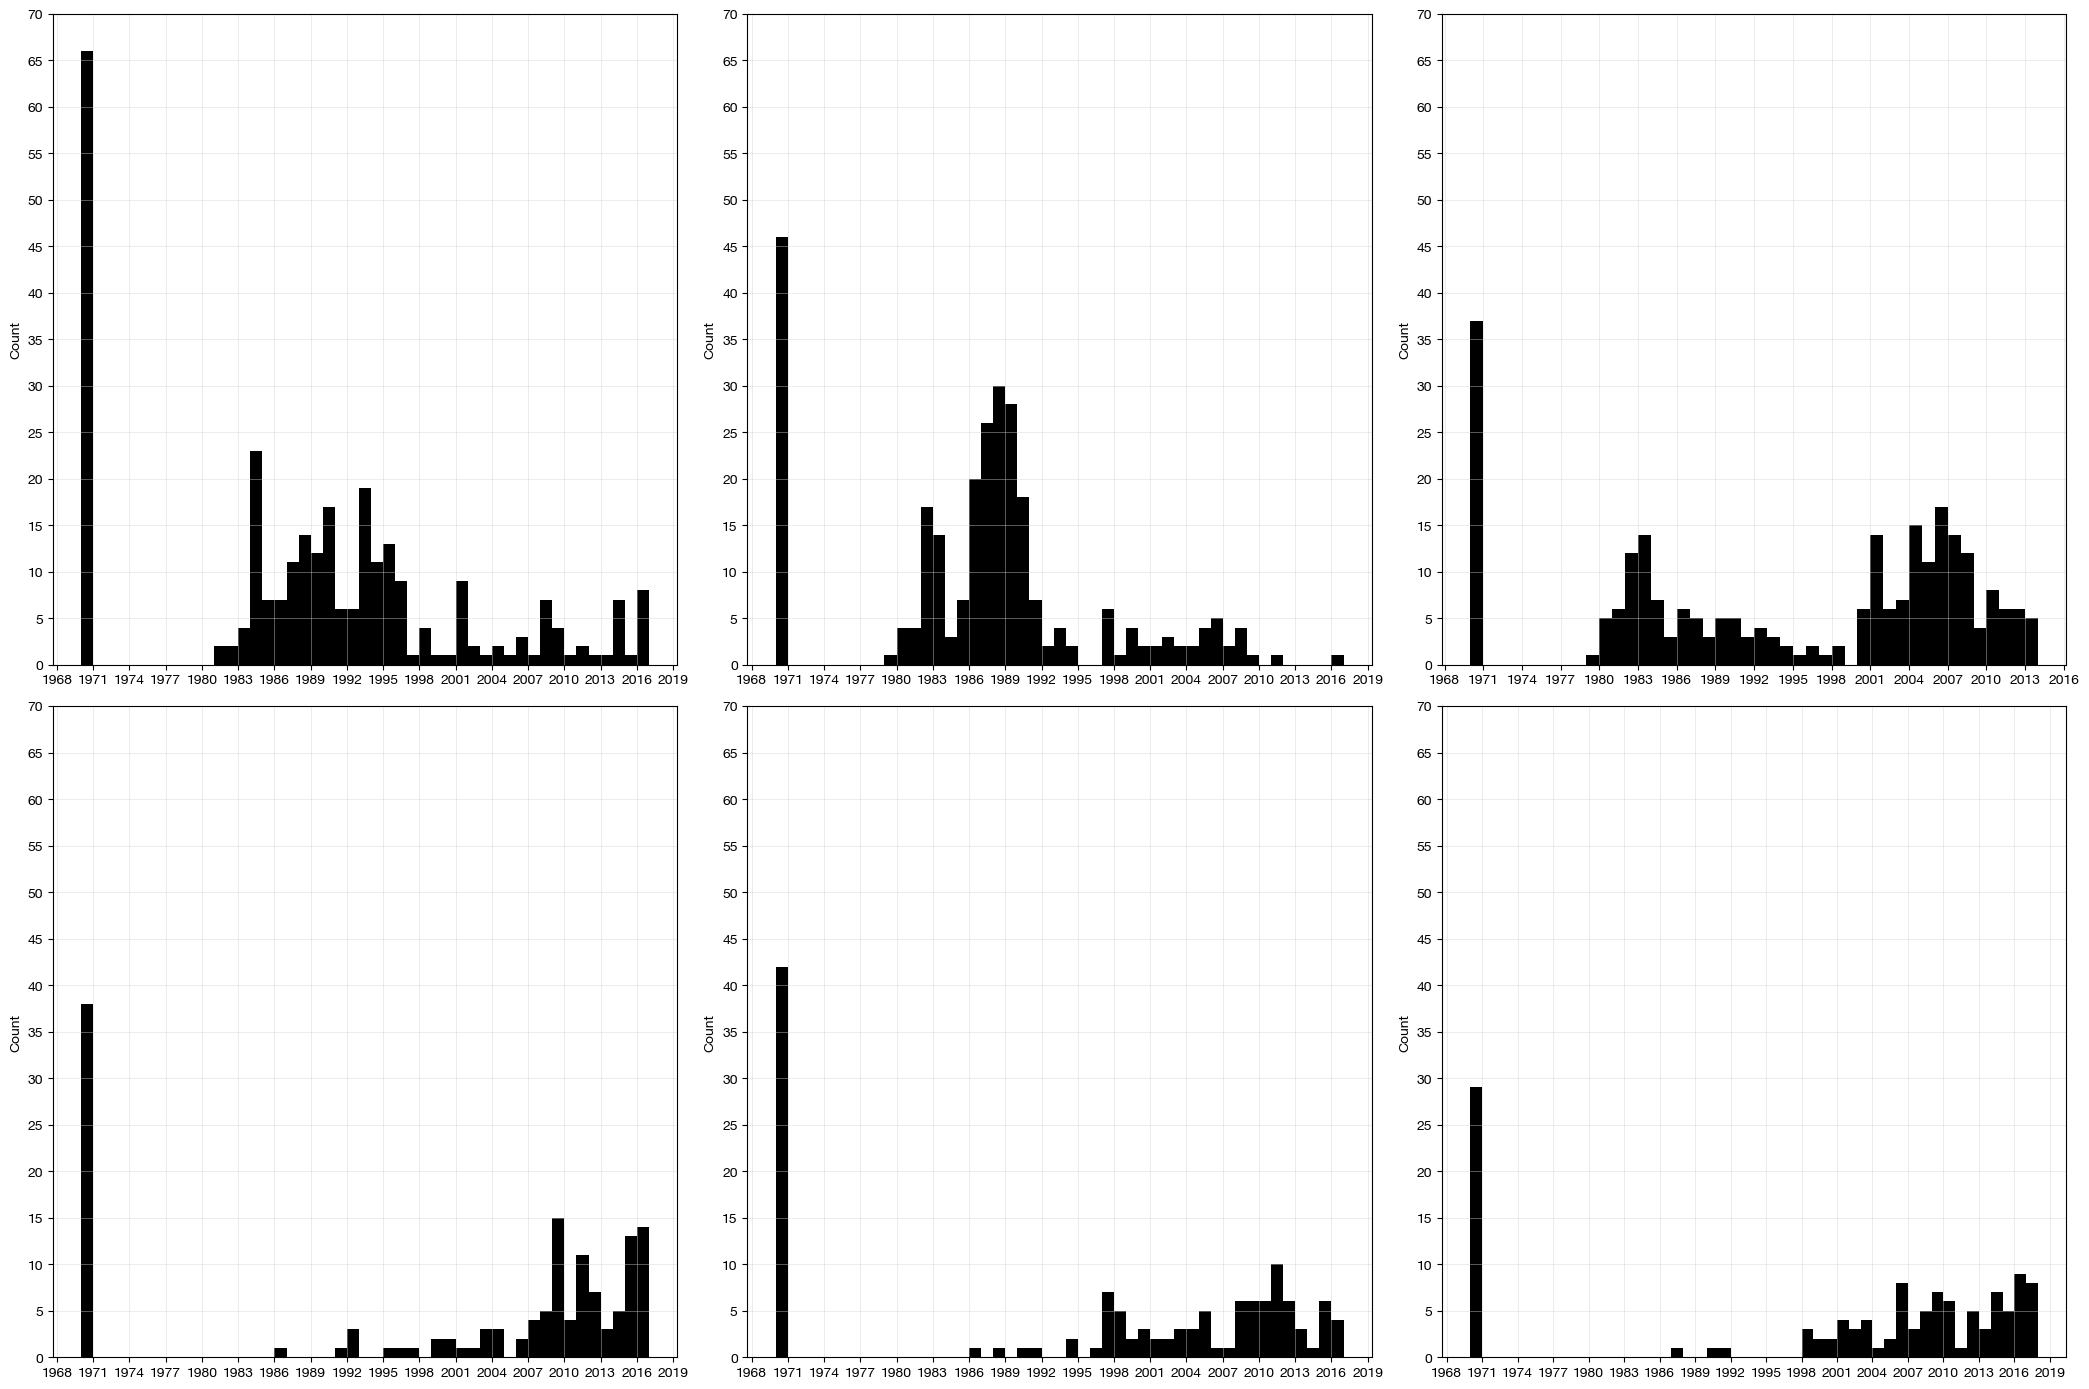

In [819]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(21, 14))
ax = axes.flatten()  # Flatten the 2D array of axes for easy access

for i in range(6):
    graph = S_sorted[i]
    graph = nx.Graph(graph)
    dates_for_cluster = nx.get_node_attributes(graph, 'date').values()
    min_date_value = min(dates_for_cluster)
    max_date_value = max(dates_for_cluster)
    values_of_dates = dict(pd.DataFrame(dates_for_cluster).astype(int).value_counts())

    ax[i].hist(dates_for_cluster, bins=len(np.arange(min_date_value, max_date_value)), color='black')
    # ax[i].set_title(f'Cluster {i+1} Dates Histogram')
    ax[i].set_ylabel('Count')
    ax[i].set_ylim(0, 70)
    ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].locator_params(axis='x', nbins=20)
    ax[i].locator_params(axis='y', nbins=20)
    ax[i].grid(True, which='both', linestyle='-', linewidth=0.5, color='lightgrey', alpha=0.6)

file_dir = "/Users/joebacchus/Desktop/PLOTS4LATEX/plots"+'barplots'+".png"
plt.tight_layout()
plt.savefig(file_dir, dpi=300)
plt.show()

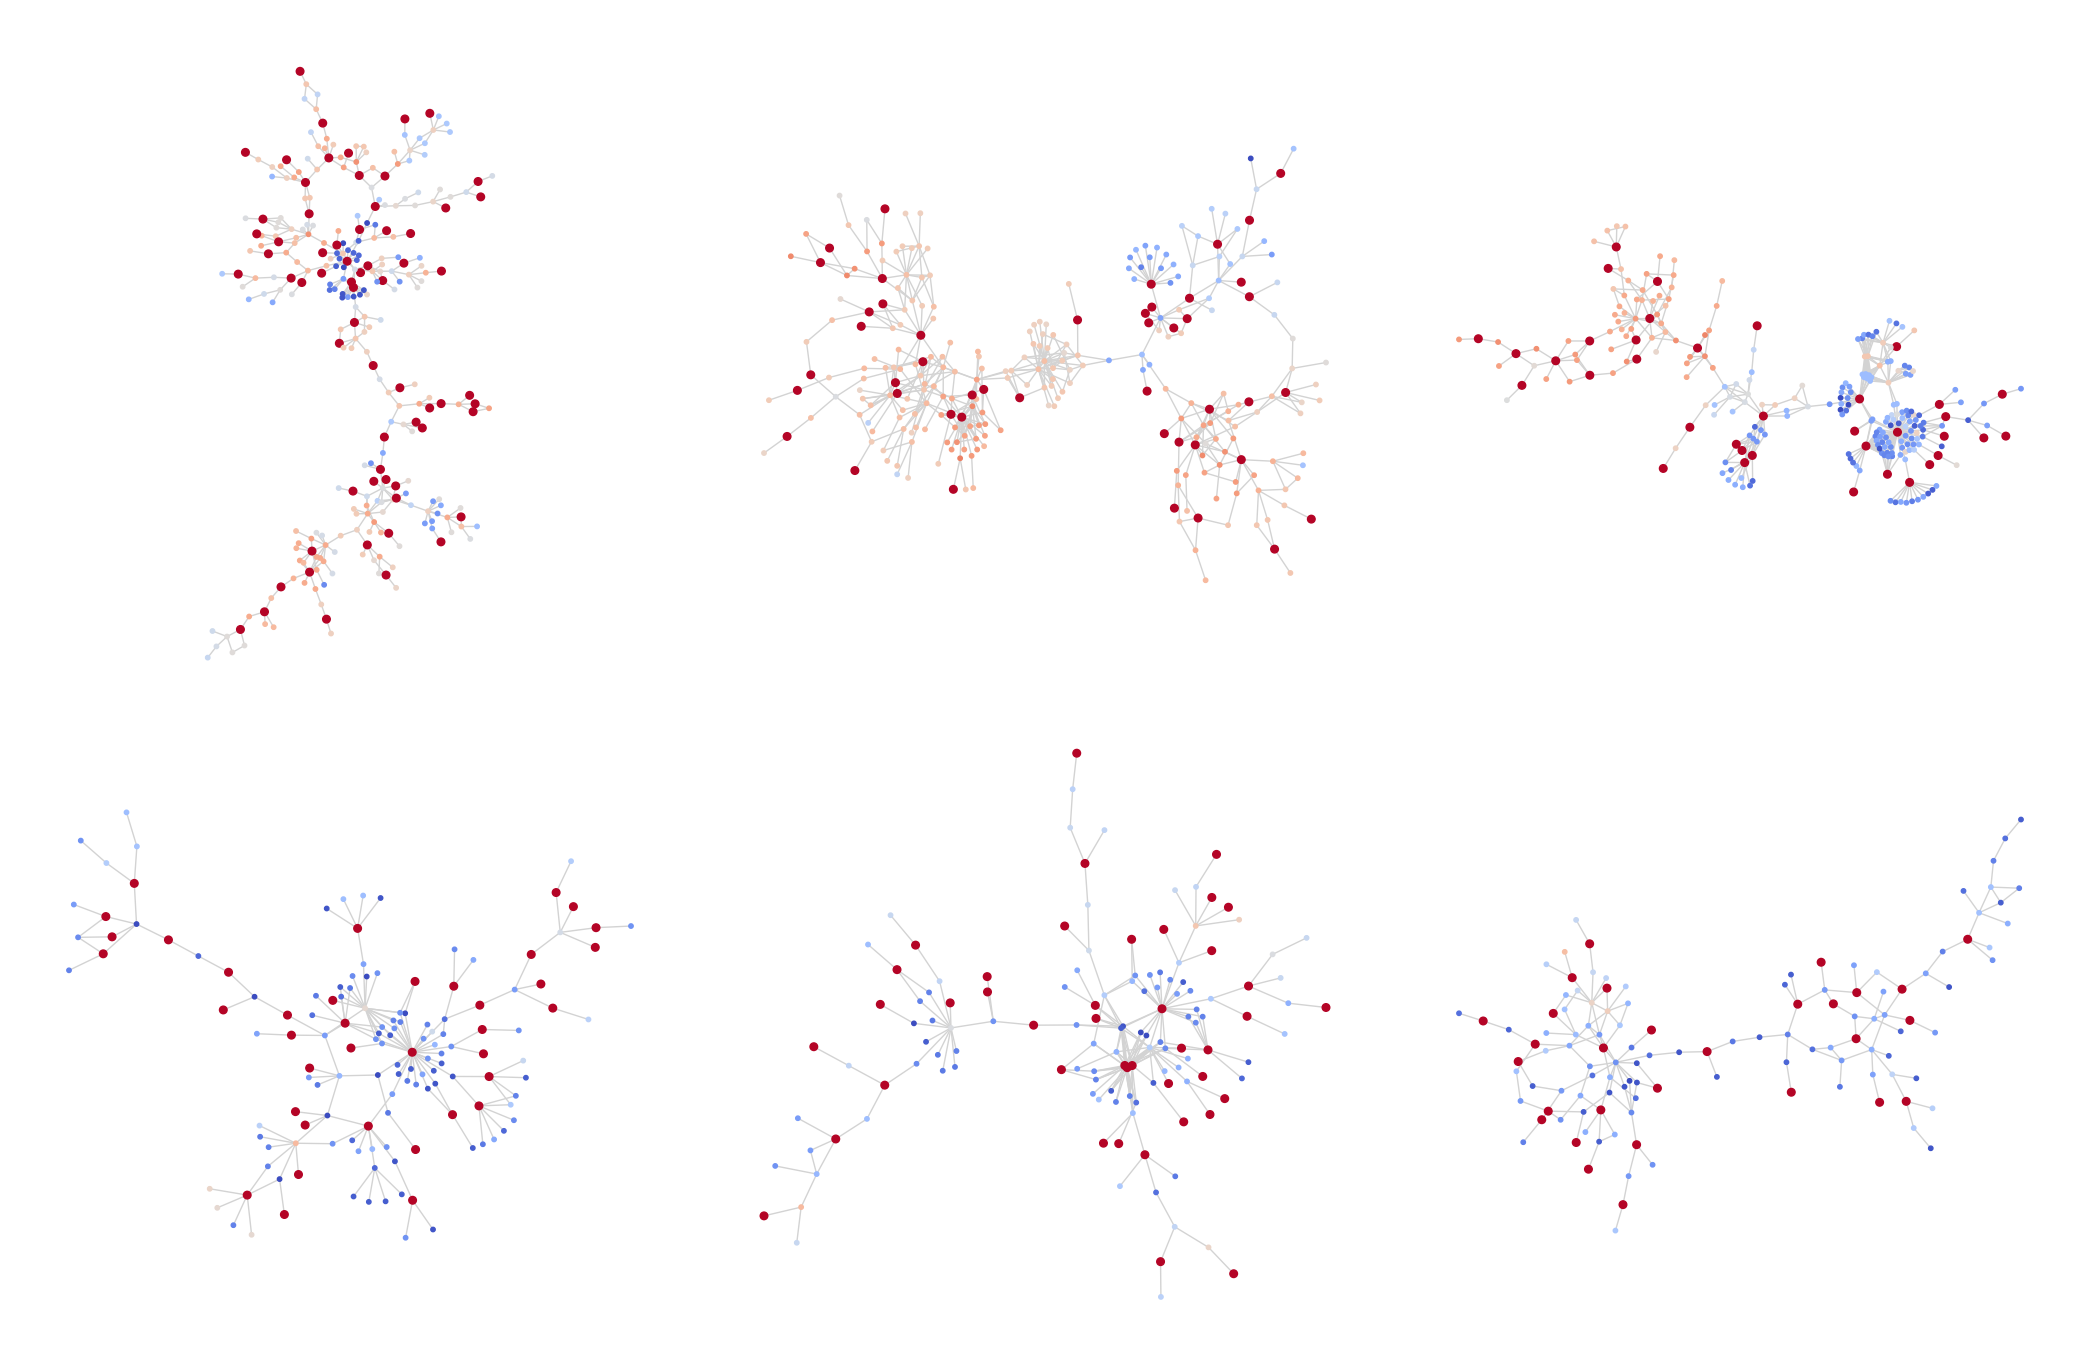

In [820]:
# Create a 2x2 grid of subplots
colormap = plt.cm.get_cmap('coolwarm_r')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(21, 14))

for i in range(6):
    graph = S_sorted[i]
    graph = nx.Graph(graph)
    
    pos_spring = nx.kamada_kawai_layout(graph)
    date_label_pos = {node: (x, y + 0.05) for node, (x, y) in pos_spring.items()}
    ipc_label_pos = {node: (x, y - 0.05) for node, (x, y) in pos_spring.items()}
    
    dates = list(nx.get_node_attributes(graph, 'date').values())
    dates_arranged = sorted(dates)
    date_labels = {node: date for node, date in zip(graph.nodes(), dates)}
    
    min_date_value = min(dates_arranged)
    max_date_value = max(dates_arranged)
    min_date_nodes = [node for node, date in date_labels.items() if date == min_date_value]
    
    ipcs = list(nx.get_node_attributes(graph, 'IPC').values())
    ipc_labels = {node: date for node, date in zip(graph.nodes(), ipcs)}
    
    normalized_dates = [(date - min_date_value) / (max(dates_arranged) - min_date_value) for date in dates]
    node_colors = [colormap(norm_date) for node, norm_date in zip(graph.nodes(), normalized_dates)]
    
    nx.draw(graph,
            pos=pos_spring, 
            with_labels=False,
            node_color=node_colors,
            cmap=colormap, 
            edge_color='lightgrey',
            node_size=[30 if node in min_date_nodes else 10 for node in graph.nodes()],
            width=1,
            arrowsize=10,
            font_color="black",
            font_size=5,
            ax=axes[i // 3, i % 3])
    
    #nx.draw_networkx_labels(graph, date_label_pos, date_labels, font_size=10, font_color='black', ax=axes[i // 3, i % 3])
    #nx.draw_networkx_labels(graph, ipc_label_pos, ipc_labels, font_size=10, font_color='black', ax=axes[i // 3, i % 3])
    
    avg_clustering_coefficient = nx.average_clustering(graph)
    avg_clustering_coefficient = 0 
    if avg_clustering_coefficient > 0:
        axes[i // 3, i % 3].text(0.8, 0.9, f'Average Clustering: {avg_clustering_coefficient:.3f}', 
                                transform=axes[i // 3, i % 3].transAxes,
                                fontsize=10, ha='right', va='center', bbox=dict(facecolor='white', alpha=0))
    
    # Add the smallest and largest dates at the top of the plot
    axes[i // 3, i % 3].text(0.9, 1, f'{min_date_value} – {max_date_value}', 
                            transform=axes[i // 3, i % 3].transAxes,
                            fontsize=10, ha='center', va='center')
    
    axes[i // 3, i % 3].set_aspect('equal')

file_dir = "/Users/joebacchus/Desktop/PLOTS4LATEX/plots"+'multiplots'+".png"
plt.tight_layout()
plt.savefig(file_dir, dpi=300, transparent=True)
plt.show()

In [ ]:
# Highlight if biotech! reduce IPC number

In [707]:
biotech_classes = [
    'A01H1',
    'A01H4',
    'A01K67',
    'A61K48',
    'C12M',
    'C12N',
    'C12P',
    'C12Q',
    'G01N27/327',
    'C07K4',
    'C07K14', 
    'C07K16',
    'C07K17',
    'C07K19',
    'C40B10',
    'G01N3353',
    'G01N3354',
    'G01N3355',
    'G01N3357',
    'G01N3368',
    'G01N3374',
    'G01N3376',
    'G01N3378',
    'G01N3388',
    'G01N3392',
    'C07G11', 
    'C07G13', 
    'C07G15',
    'C02F3/34',
    'A61K38',
    'A61K39',
    'C40B50/06',
    'A61K35/12', 'A61K35/13', 'A61K35/14', 'A61K35/15', 'A61K35/16', 'A61K35/17', 'A61K35/18', 'A61K35/19', 'A61K35/20', 'A61K35/21', 'A61K35/22', 'A61K35/23', 'A61K35/24', 'A61K35/25', 'A61K35/26', 'A61K35/27', 'A61K35/28', 'A61K35/29', 'A61K35/30', 'A61K35/31', 'A61K35/32', 'A61K35/33', 'A61K35/34', 'A61K35/35', 'A61K35/36', 'A61K35/37', 'A61K35/38', 'A61K35/39', 'A61K35/40', 'A61K35/41', 'A61K35/42', 'A61K35/43', 'A61K35/44', 'A61K35/45', 'A61K35/46', 'A61K35/47', 'A61K35/48', 'A61K35/49', 'A61K35/50', 'A61K35/51', 'A61K35/52', 'A61K35/53', 'A61K35/54', 'A61K35/55', 'A61K35/56', 'A61K35/57', 'A61K35/58', 'A61K35/59', 'A61K35/60', 'A61K35/61', 'A61K35/62', 'A61K35/63', 'A61K35/64', 'A61K35/65', 'A61K35/66', 'A61K35/67', 'A61K35/68', 'A61K35/69', 'A61K35/70', 'A61K35/71', 'A61K35/72', 'A61K35/73', 'A61K35/74', 'A61K35/75', 'A61K35/76', 'A61K35/77', 'A61K35/78', 'A61K35/79',
    'C40B40/02', 'C40B40/03', 'C40B40/04', 'C40B40/05', 'C40B40/06', 'C40B40/07', 'C40B40/08',
    'G06F19/10', 'G06F19/11', 'G06F19/12', 'G06F19/13', 'G06F19/14', 'G06F19/15', 'G06F19/16', 'G06F19/17', 'G06F19/18',
    'G06F19/20', 'G06F19/21', 'G06F19/22', 'G06F19/23', 'G06F19/24'
]


In [708]:
#biotech_classes = ["A01H001", "A01H004", "A01K067", "A01K035/12", "A01K035/13", "A01K035/14","A01K035/15", "A01K035/16", "A01K035/17", "A01K035/18", "A01K035/19", "A01K035/20", "A01K035/21", "A01K035/22", "A01K035/23", "A01K035/24", "A01K035/25", "A01K035/26", "A01K035/27", "A01K035/28", "A01K035/29", "A01K035/30", "A01K035/31", "A01K305/32", "A01K035/33", "A01K035/34", "A01K035/35", "A01K035/36", "A01K035/37", "A01K035/38", "A01K035/39", "A01K035/40", "A01K035/41", "A01K035/42", "A01K035/43", "A01K035/44", "A01K035/45", "A01K035/46", "A01K035/47", "A01K035/48", "A01K035/49", "A01K035/50", "A01K035/51", "A01K035/52", "A01K035/53", "A01K035/54", "A01K035/55", "A01K035/56", "A01K035/57", "A01K035/58", "A01K035/59", "A01K035/60", "A01K035/61", "A01K035/62", "A01K035/63", "A01K035/64", "A01K035/65", "A01K035/66", "A01K035/67", "A01K035/68", "A01K035/69", "A01K035/70", "A01K035/71", "A01K035/72", "A01K035/73", "A01K035/74", "A01K035/75", "A01K035/76", "A01K035/77", "A01K035/78", "A01K035/79", "A61K38", "A61K039", "A16K048", "C02F003/34", "C07G011", "C07G013", "C07G015", "C07K004", "C07K014", "C07K016", "C07K017", "C07K019", "C12M", "C12N", "C12P", "C12Q", "C40B010", "C40B040/02", "C40B040/03","C40B040/04", "C40B040/05", "C40B040/06", "C40B040/07", "C40B040/08", "C40B050/06", "G01N027/327", "G01N033/53", "G01N033/54", "G01N033/55", "G01N033/57", "G01N033/68", "G01N033/74", "G01N033/76", "G01N033/78", "G01N033/88", "G01N033/92", "G06F019/10","G06F019/11", "G06F019/12", "G06F019/13", "G06F019/14", "G06F019/15", "G06F019/16", "G06F019/17", "G06F019/18", "G06F019/20", "G06F019/21", "G06F019/22", "G06F019/23", "G06F019/24"]

#### EPO VERSION

In [706]:
EPO_IPCs = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Patent data/202001_EPO_IPC.txt', sep='|')
EPO_IPCs = EPO_IPCs[['appln_id','IPC']]

appln_id          IPC
0                 1   G06K007/00
1                 1   G06K017/00
2                 1  G06K019/077
3                 1   H01R012/18
4                 1   H04M001/02
...             ...          ...
14184524  511943786   D04B027/26
14184525  511944146   D04B027/26
14184526  512029478   B01L003/00
14184527  512029478   B03C005/00
14184528  512029478   B03C005/02

[14184529 rows x 2 columns]

In [718]:
EPO_PATENTS = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Patent data/202001_EPO_Inventor_reg.txt',sep='|')

In [709]:
biotech_pd=pd.DataFrame()
for i in tqdm(range(len(biotech_classes))):
    filt_for_type = EPO_IPCs['IPC'].str.contains('^'+biotech_classes[i]).fillna(False)
    biotech_spec = EPO_IPCs.loc[filt_for_type]
    biotech_pd = pd.concat([biotech_pd, biotech_spec], ignore_index=True)

100%|█████████████████████████████████████████| 121/121 [15:37<00:00,  7.75s/it]


In [ ]:
biotech_patents_EPO = list(set(list(EPO_PATENTS.merge(biotech_pd, left_on = 'appln_id', right_on = 'appln_id')['app_nbr'])))

#### PCT VERSION (REDUNDENT!)

In [724]:
PCT_IPCs = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Patent data/202001_PCT_IPC.txt', sep='|')

In [730]:
EPO_PCT = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Patent data/202001_EPO_PCT.txt', sep='|')

In [733]:
PCT_IPC_USE = EPO_PCT.merge(PCT_IPCs)[['app_nbr','IPC']].drop_duplicates()

app_nbr          IPC
0         EP20000900148   G01J005/16
1         EP20000900214   A45F003/08
2         EP20000900214   A45F003/14
3         EP20000900214   A45F003/04
4         EP20000900214   A45C011/38
...                 ...          ...
12602604  EP19990974269   B29D030/06
12602605  EP19990974269   B60C015/00
12602606  EP19990974269  B60C015/024
12602607  EP19990974269   B29L030/00
12602608  EP19990974269   B29C033/02

[12602047 rows x 2 columns]

In [734]:
biotech_pd=pd.DataFrame()
for i in tqdm(range(len(biotech_classes))):
    filt_for_type = PCT_IPC_USE['IPC'].str.contains('^'+biotech_classes[i]).fillna(False)
    biotech_spec = PCT_IPC_USE.loc[filt_for_type]
    biotech_pd = pd.concat([biotech_pd, biotech_spec], ignore_index=True)

100%|█████████████████████████████████████████| 121/121 [20:04<00:00,  9.95s/it]


In [738]:
biotech_patents_PCT = list(set(list(biotech_pd['app_nbr'])))

In [744]:
len(biotech_patents_PCT)

170517

In [743]:
len(biotech_patents_EPO)

142876

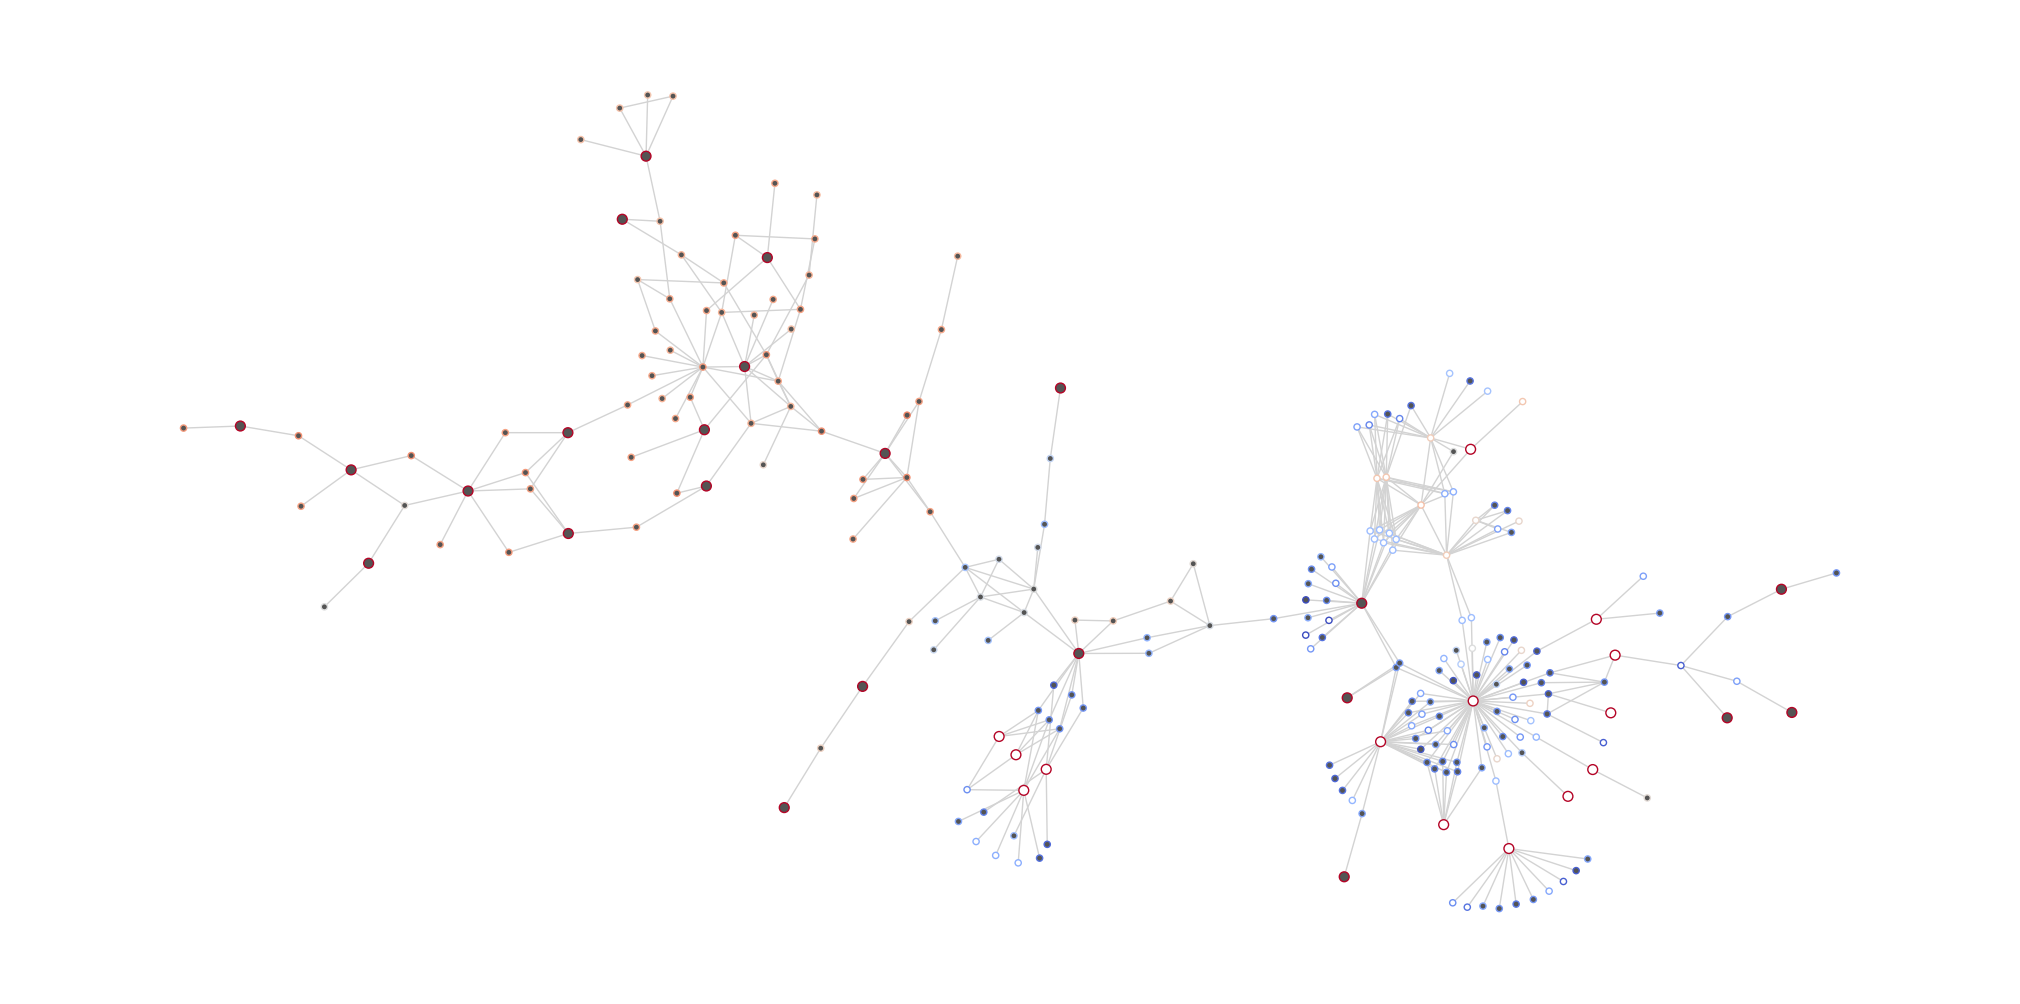

In [776]:
colormap = plt.cm.get_cmap('coolwarm_r')
fig = plt.figure(figsize=(20, 20))

graph = S_sorted[2]
graph = nx.Graph(graph)

pos_spring = nx.kamada_kawai_layout(graph)
date_label_pos = {node: (x, y + 0.02) for node, (x, y) in pos_spring.items()}
ipc_label_pos = {node: (x, y - 0.05) for node, (x, y) in pos_spring.items()}

dates = list(nx.get_node_attributes(graph, 'date').values())
dates_arranged = sorted(dates)
date_labels = {node: date for node, date in zip(graph.nodes(), dates)}

min_date_value = min(dates_arranged)
max_date_value = max(dates_arranged)
min_date_nodes = [node for node, date in date_labels.items() if date == min_date_value]

ipcs = list(nx.get_node_attributes(graph, 'IPC').values())
ipc_labels = {node: date for node, date in zip(graph.nodes(), ipcs)}

normalized_dates = [(date - min_date_value) / (max(dates_arranged) - min_date_value) for date in dates]
node_colors = [colormap(norm_date) for node, norm_date in zip(graph.nodes(), normalized_dates)]
node_colors = [(1, 1, 1, 1) if node in biotech_patents_EPO else (0.33, 0.33, 0.33, 1.0) for node in graph.nodes()]
nodeedge_colors = [colormap(norm_date) for node, norm_date in zip(graph.nodes(), normalized_dates)]

nx.draw(graph,
        pos=pos_spring, 
        with_labels=False,
        node_color=node_colors,
        cmap=colormap, 
        edge_color='lightgrey',
        edgecolors=nodeedge_colors,
        node_size=[50 if node in min_date_nodes else 20 for node in graph.nodes()],
        width=1,
        arrowsize=10,
        font_color="black",
        font_size=5)

#nx.draw_networkx_labels(graph, pos=date_label_pos, font_size=5, font_color='black')

#nodes.set_edgecolor([(0.33, 0.33, 0.33, 1.0) if node in biotech_patents_EPO else 'lightgrey' for node in graph.nodes()])
plt.gca().set_aspect('equal')

avg_clustering_coefficient = nx.average_clustering(graph)
avg_clustering_coefficient = 0 
if avg_clustering_coefficient > 0:
    plt.text(0.8, 0.9, f'Average Clustering: {avg_clustering_coefficient:.3f}', 
             transform=plt.gca().transAxes,
             fontsize=10, ha='right', va='center', bbox=dict(facecolor='white', alpha=0))

file_dir = "/Users/joebacchus/Desktop/PLOTS4LATEX/plots" + 'multiplots' + ".png"
plt.savefig(file_dir, dpi=300, transparent=True)
plt.show()